In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # visualization
!pip install seaborn as sns -q --upgrade pip # visualization with seaborn v0.11.1
import seaborn as sns # visualization
import missingno as msno # missing values pattern visualization
#set seed
import random
seed = 41
!pip install dabl -q --upgrade pip
import dabl # quick exploration and model assessment



import warnings # supress warnings
warnings.filterwarnings('ignore')

# set pandas display option
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)





# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Load the data 
train_df = pd.read_csv('../input/widsdatathon2021/TrainingWiDS2021.csv')
test_df = pd.read_csv('../input/widsdatathon2021/UnlabeledWiDS2021.csv')
data_dictionary_df = pd.read_csv("../input/widsdatathon2021/DataDictionaryWiDS2021.csv")

# Drop first column because it is identical to index
train_df.drop(columns = ['Unnamed: 0', 'encounter_id', 'hospital_id'], axis = 1, inplace = True)
test_df.drop(['Unnamed: 0', 'encounter_id', 'hospital_id'], axis = 1, inplace = True)

# display the dataset
train_df.head().style.set_caption('Sample of training data')

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,68.000000,22.732803,0,Caucasian,M,180.300000,Floor,Floor,92,admit,CTICU,0.541667,0,73.900000,2.300000,113.000000,502.010000,0,0,0.400000,31.000000,2.510000,nan,3.000000,6.000000,0.000000,4.000000,168.000000,118.000000,27.400000,0,40.000000,nan,nan,nan,nan,36.000000,134.000000,39.300000,nan,0,14.100000,46.000000,32.000000,68.000000,37.000000,68.000000,37.000000,119.000000,72.000000,66.000000,40.000000,89.000000,46.000000,89.000000,46.000000,34.000000,10.000000,100.000000,74.000000,122.000000,64.000000,131.000000,73.000000,131.000000,73.000000,39.900000,37.200000,nan,nan,68.000000,63.000000,68.000000,63.000000,119.000000,108.000000,nan,nan,86.000000,85.000000,86.000000,85.000000,26.000000,18.000000,100.000000,74.000000,nan,nan,131.000000,115.000000,131.000000,115.000000,39.500000,37.500000,2.300000,2.300000,0.400000,0.400000,31.000000,30.000000,8.500000,7.400000,2.510000,2.230000,168.000000,109.000000,19.000000,15.000000,8.900000,8.900000,27.400000,27.400000,nan,nan,1.300000,1.000000,233.000000,233.000000,4.000000,3.400000,136.000000,134.000000,14.100000,14.100000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

In [3]:
train_df.shape, test_df.shape

((130157, 178), (10234, 177))

In [4]:
# let's inspect the variable values
for var in train_df.columns:
    print(var, train_df[var].unique()[0:20], '\n')

age [68. 77. 25. 81. 19. 67. 59. 70. 45. 50. 72. 80. 48. 65. 78. 30. 46. 39.
 79. 58.] 

bmi [22.73280282 27.421875   31.95274882 22.63554823         nan 27.55561067
 57.45100248 25.70770213 28.25705249 27.3828125  38.18906706 23.38317807
 25.84571744 28.40892909 37.0102781  28.37610001 35.65998942 21.96376348
 29.50995926 26.01070291] 

elective_surgery [0 1] 

ethnicity ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown'] 

gender ['M' 'F' nan] 

height [180.3 160.  172.7 165.1 188.  190.5 165.  170.2 175.3 154.9 193.  167.6
 177.8 162.6 152.4 149.9 182.9 162.5 151.8 157.5] 

hospital_admit_source ['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other'] 

icu_admit_source ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan] 

icu_id [ 92 

d1_arterial_ph_max [ nan 7.45 7.44 7.42 7.38 7.62 7.35 7.49 7.37 7.33 7.36 7.43 7.48 7.34
 7.53 7.39 7.4  7.29 7.32 7.46] 

d1_arterial_ph_min [ nan 7.45 7.34 7.42 7.38 6.99 7.35 7.26 7.17 7.37 7.33 7.36 6.89 7.47
 7.24 7.41 7.44 7.29 7.27 7.4 ] 

d1_arterial_po2_max [ nan  51. 337. 370.  89. 256. 141. 174.  77. 283. 104.  84.  85. 140.
 175. 167. 136. 373. 257. 119.] 

d1_arterial_po2_min [ nan  51. 102. 370.  89.  92. 141.  80.  77.  55. 104.  84.  85.  78.
 131. 167.  59.  46.  69.  67.] 

d1_pao2fio2ratio_max [        nan  54.8       342.5       370.         92.        352.5
 337.5       275.        283.        260.        233.3333333 379.1666667
 583.3333333 417.5       272.        298.8372093 255.5555556 310.
 325.        466.       ] 

d1_pao2fio2ratio_min [        nan  51.        236.6666667 370.         92.        352.5
 161.        275.        101.4285714 260.        233.3333333 195.
 436.6666667 417.5       147.5       245.        150.        310.
 307.5       466.       ] 


In [5]:
# make list of variables  types for train set

# numerical: discrete vs continuous

continuous = [var for var in train_df.columns if train_df[var].dtype!='object' and var!='diabetes_mellitus' and train_df[var].nunique()>10]

# categorical
categorical = [var for var in train_df.columns if train_df[var].dtype =='object' or train_df[var].nunique()<=3 and var!='diabetes_mellitus']

discrete = [var for var in train_df.columns if train_df[var].dtype!='object' and train_df[var].nunique()>3 and var not in continuous ]


print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))


There are 3 discrete variables
There are 154 continuous variables
There are 20 categorical variables


In [6]:
# make list of variables  types for test set

# numerical: discrete vs continuous

cont = [var for var in test_df.columns if test_df[var].dtype!='object' and var!='diabetes_mellitus' and test_df[var].nunique()>10]

# categorical
cat = [var for var in test_df.columns if test_df[var].dtype =='object' or test_df[var].nunique()<=3 and var!='diabetes_mellitus']

dis = [var for var in test_df.columns if test_df[var].dtype!='object' and test_df[var].nunique()>3 and var not in cont ]


print('There are {} discrete variables'.format(len(dis)))
print('There are {} continuous variables'.format(len(cont)))
print('There are {} categorical variables'.format(len(cat)))

There are 3 discrete variables
There are 154 continuous variables
There are 20 categorical variables


Check if there are any unique values in train that doesn't exist in test

In [7]:
def checker(lis, df1, df2):
    for var in lis:
        unique_to_df1 = [
            x for x in df1[var].unique() if x not in df2[var].unique()
        ]
    print(f'There are {len(unique_to_df1)} categorical values unique to train set') 
    return unique_to_df1

In [8]:
unique_to_train = checker(cat, train_df, test_df)
unique_to_train

There are 0 categorical values unique to train set


[]

In [9]:
cat

['elective_surgery',
 'ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'readmission_status',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [10]:
t1 = train_df.groupby(['immunosuppression'])['immunosuppression'].count() / len(train_df)
t2 = test_df.groupby(['immunosuppression'])['immunosuppression'].count() / len(test_df)
temp = pd.concat([t1, t2], axis = 1)

If data are not missing at random, it is a good idea to replace missing observations by the mean / median / mode AND flag those missing observations as well with a Missing Indicator. A Missing Indicator is an additional binary variable, which indicates whether the data was missing for an observation (1) or not (0).

# Group missing values
Arbitrary value imputation for categorical variables
This is the most widely used method of missing data imputation for categorical variables. This method consists in treating missing data as an additional label or category of the variable. All the missing observations are grouped in the newly created label 'Missing'.

This is in essence, the equivalent of replacing by an arbitrary value for numerical variables.

The beauty of this technique resides on the fact that it does not assume anything about the fact that the data is missing. It is very well suited when the number of missing data is high.

Advantages
Easy to implement
Fast way of obtaining complete datasets
Can be integrated in production (during model deployment)
Captures the importance of "missingness" if there is one
No assumption made on the data
Limitations
If the number of NA is small, creating an additional category may cause trees to over-fit
For categorical variables this is the method of choice, as it treats missing values as a separate category, without making any assumption on the variable or the reasons why data could be missing. 

In [11]:
shallow_copy = train_df.copy()

In [12]:
def missing_zero_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {df.index.name:'col_name', 0 : 'Missing Values', 1 : '% of Total Values'})
        mz_table['Data_type'] = df.dtypes
        mz_table = mz_table[mz_table.iloc[:,1] != 0 ].sort_values('% of Total Values', ascending=False)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n There are " + str(mz_table.shape[0]) + " columns that have missing values.")
        return mz_table.reset_index()
missing = missing_zero_values_table(shallow_copy[categorical])
missing.style.background_gradient(cmap='Reds')

Your selected dataframe has 20 columns and 130157 Rows.
There are 5 columns that have missing values.


,index,Missing Values,% of Total Values,Data_type
0,hospital_admit_source,33198,25.510000,object
1,ethnicity,1587,1.220000,object
2,gcs_unable_apache,709,0.540000,float64
3,icu_admit_source,240,0.180000,object
4,gender,66,0.050000,object


In [52]:
missing_tr = missing_zero_values_table(train_df[categorical])
col_to_drop = list(missing_tr[missing_tr['% of Total Values'] > 50]['index'])
col_to_drop

Your selected dataframe has 20 columns and 130157 Rows.
There are 5 columns that have missing values.


[]

In [13]:
missing = missing_zero_values_table(test_df[categorical])
missing.style.background_gradient(cmap='Reds')

Your selected dataframe has 20 columns and 10234 Rows.
There are 5 columns that have missing values.


,index,Missing Values,% of Total Values,Data_type
0,hospital_admit_source,2733,26.710000,object
1,ethnicity,204,1.990000,object
2,gcs_unable_apache,61,0.600000,float64
3,icu_admit_source,25,0.240000,object
4,gender,5,0.050000,object


Same missing categories in the test set too

Text(0, 0.5, 'Number of different categories')

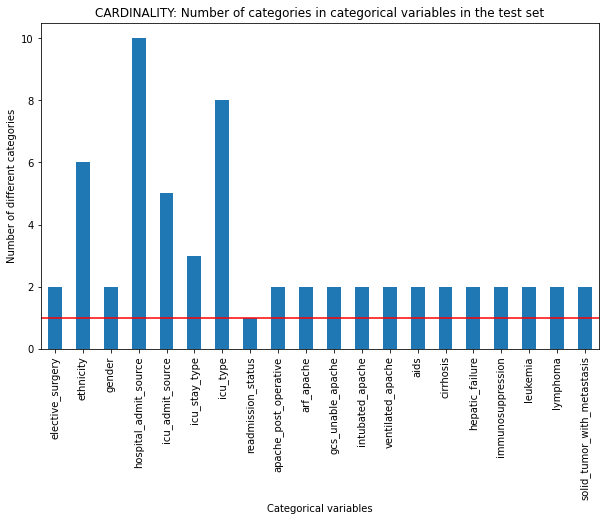

In [14]:
# plot number of categories per categorical variable

fig = test_df[categorical].nunique().plot.bar(figsize=(10,6))
# plot a threshold of categories that has only one sub-category
fig.axhline(y=1, color='red')
plt.title('CARDINALITY: Number of categories in categorical variables in the test set')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

In [15]:
def fill_na(df):
    for col in categorical:
        if df[col].dtypes == 'object': 
            df[col].fillna('missing', inplace = True)
        elif df[col].dtypes != 'object': 
            df[col] = df[col].astype('str')
            df[col].fillna('missing', inplace = True)
    return df

In [16]:
group_miss = fill_na(shallow_copy)

In [17]:
missing = missing_zero_values_table(group_miss[categorical])
missing.style.background_gradient(cmap='Reds')

Your selected dataframe has 20 columns and 130157 Rows.
There are 0 columns that have missing values.


,index,Missing Values,% of Total Values,Data_type


<Figure size 360x504 with 0 Axes>

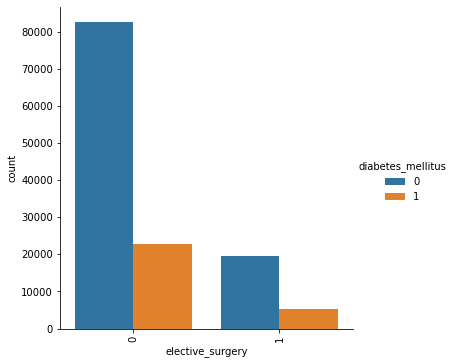

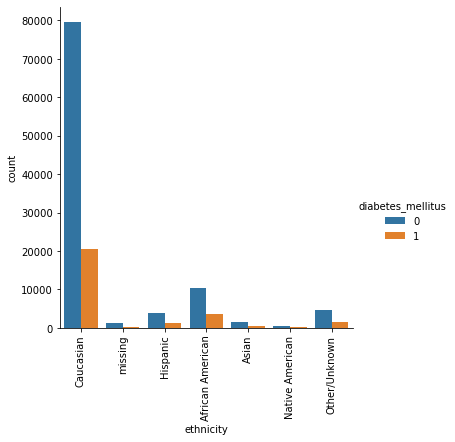

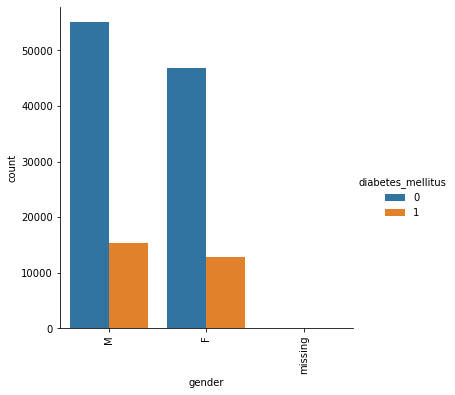

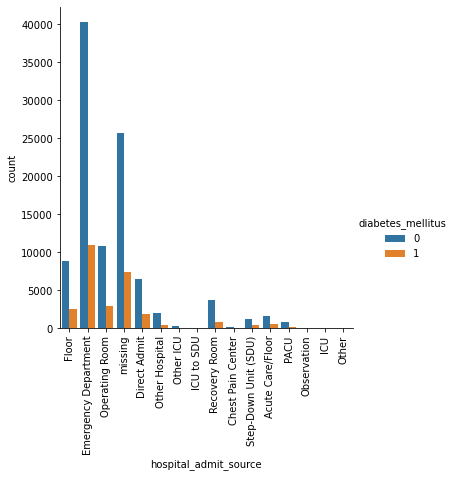

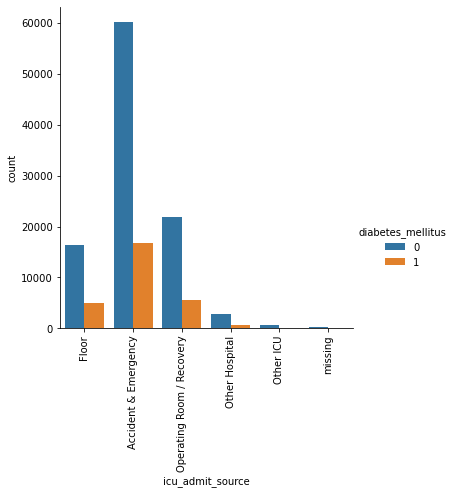

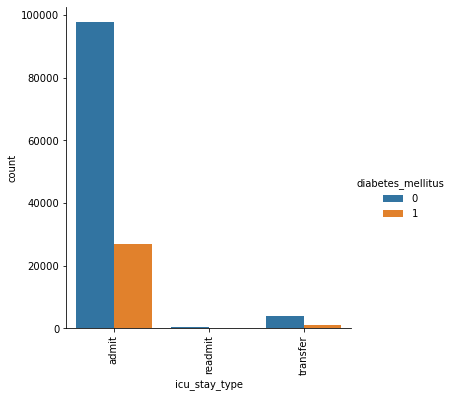

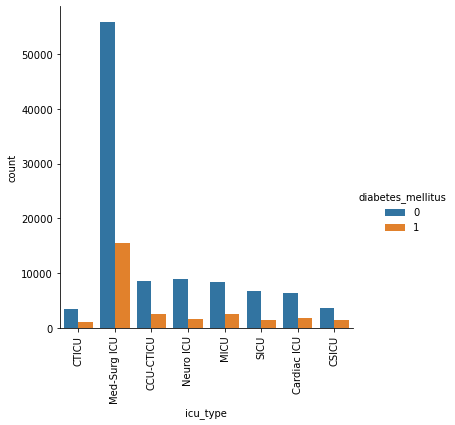

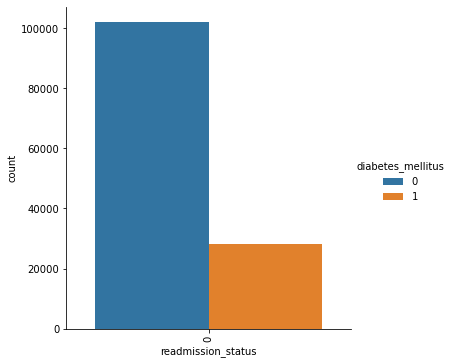

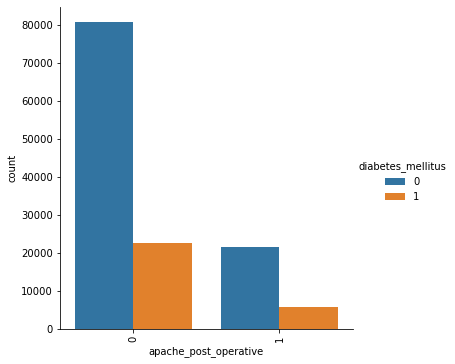

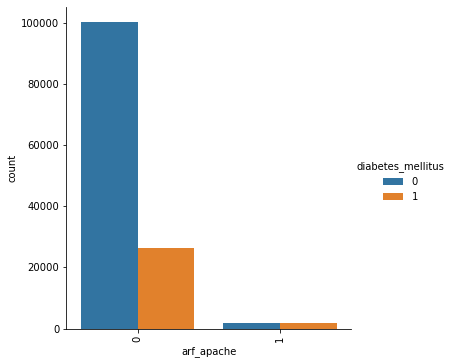

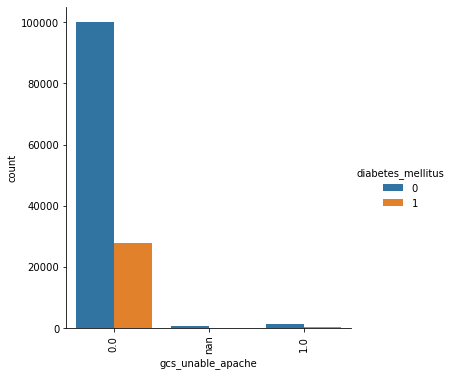

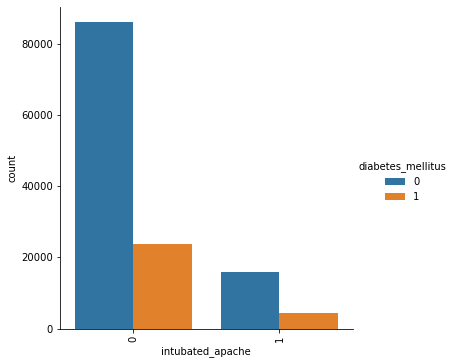

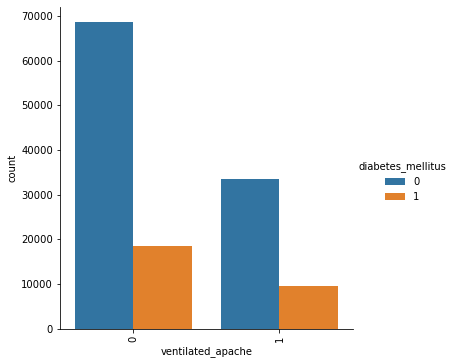

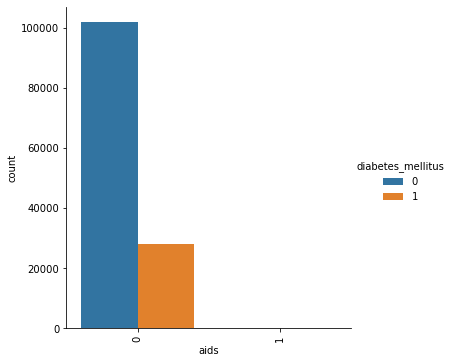

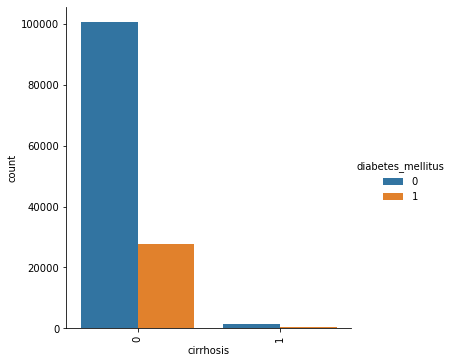

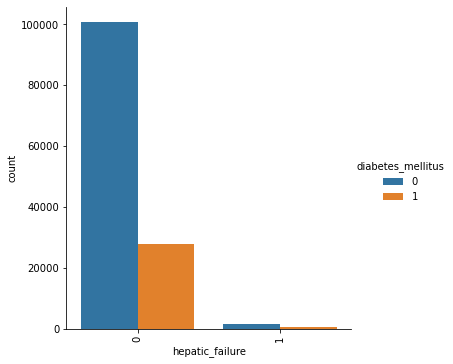

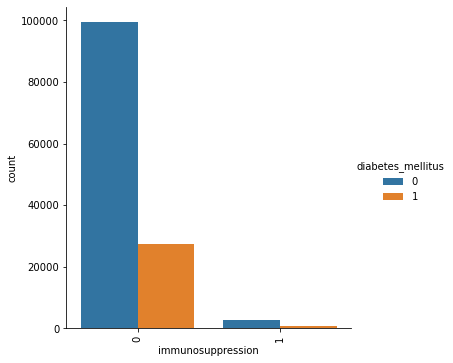

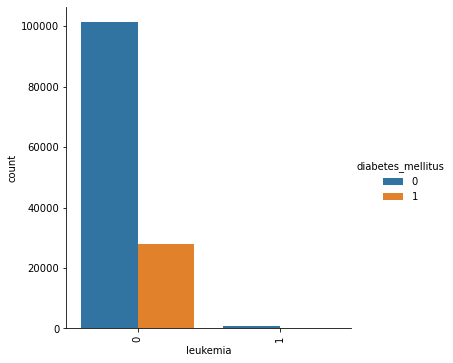

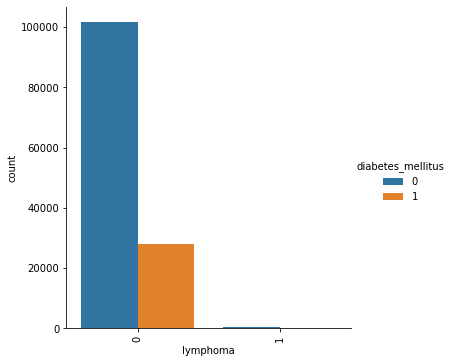

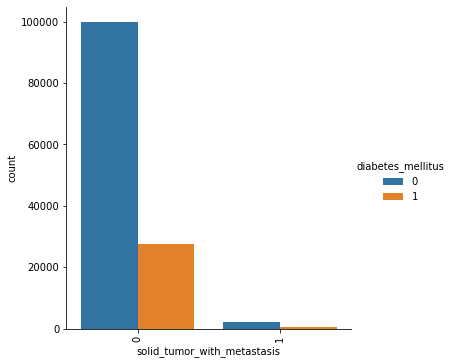

In [18]:
# for each categorical variable
fig = plt.figure(figsize=(5, 7))
for col in categorical:
    t = sns.catplot(data = group_miss, x = col, hue = 'diabetes_mellitus', kind = 'count')
    t.set_xticklabels(rotation=90)
    plt.show()

There are some labels that might be considered to drop to reduce cardinality of the categorical variables. Also, There are some variables that has only one label, we may consider to drop them too. However, will decide later when we compare algorithms after fully process the data and split them into train and test!

<hr>
<hr>

# Reduce cardinality
Group rare labels into one category - apply to train, then will do again to test data when finalize the preprocess with the pipeline step.

For each of the categorical variables, some labels appear in less than 5% of and many appear in less than 5% These are infrequent labels or Rare Values and could cause over-fitting. Also, missing values in some of the variables have a significant number.

Text(0, 0.5, 'Number of different categories')

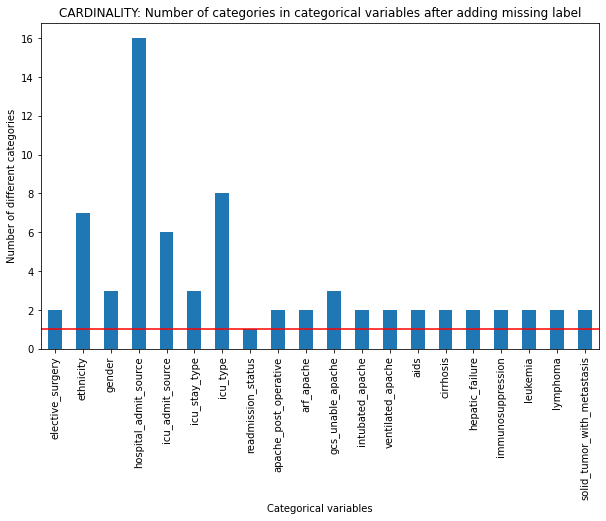

In [19]:
# plot number of categories per categorical variable

fig = group_miss[categorical].nunique().plot.bar(figsize=(10,6))
# plot a threshold of categories that has only one sub-category
fig.axhline(y=1, color='red')
plt.title('CARDINALITY: Number of categories in categorical variables after adding missing label')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

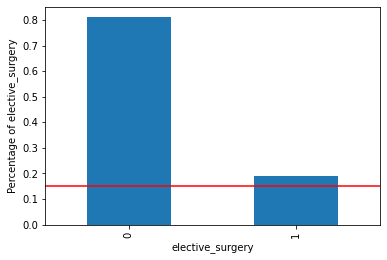

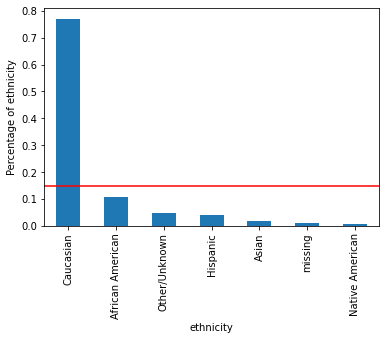

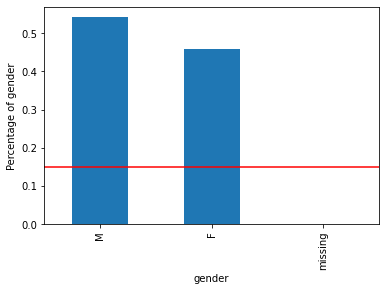

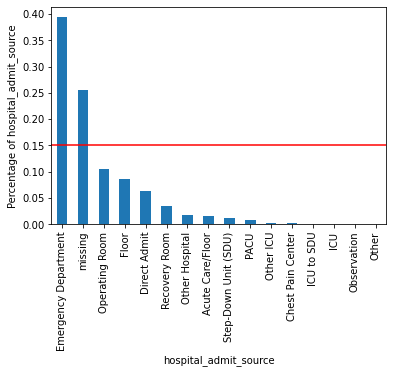

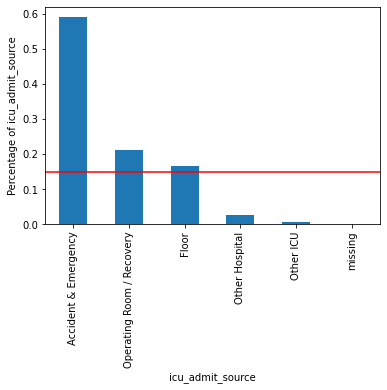

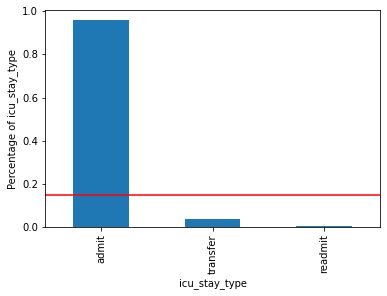

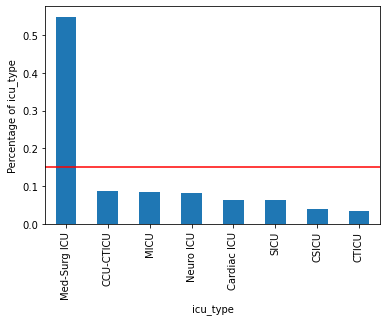

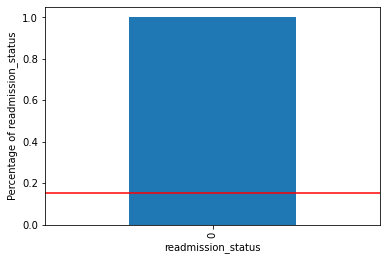

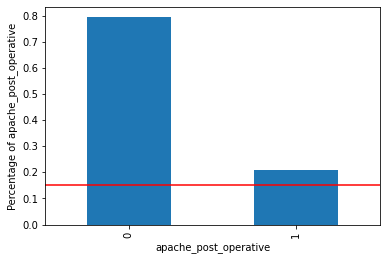

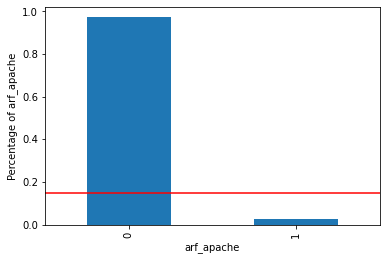

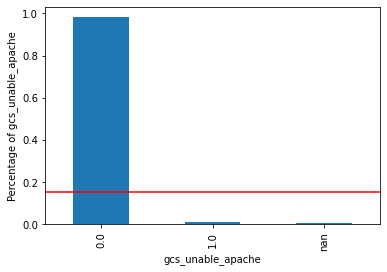

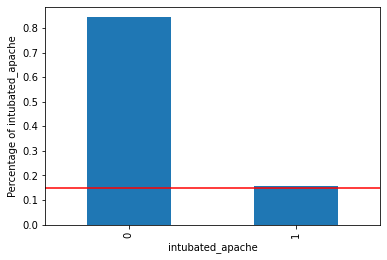

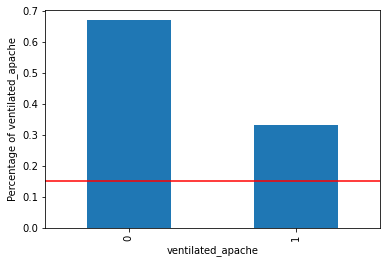

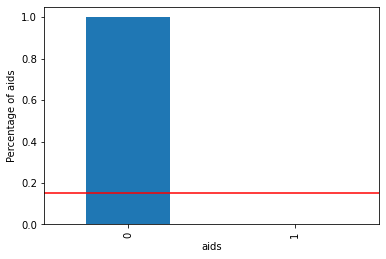

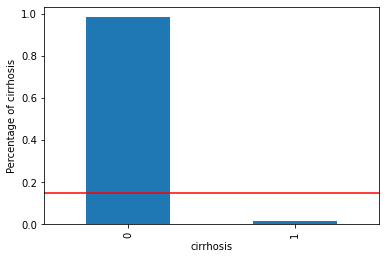

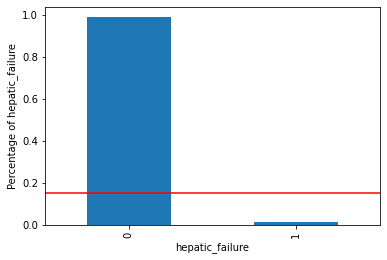

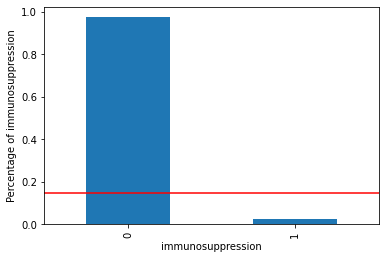

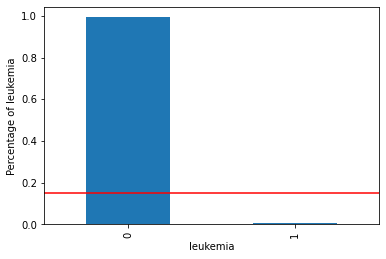

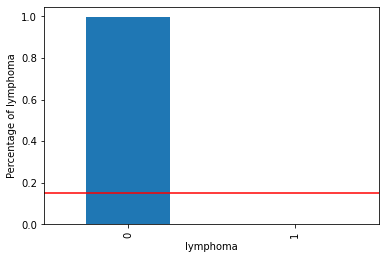

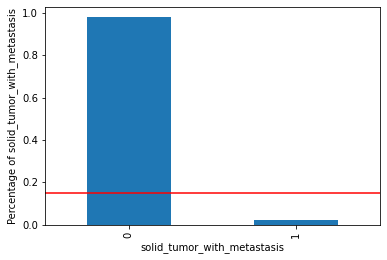

In [20]:
total_labels = len(group_miss)

# for each categorical variable
for col in categorical:
    # calculate how many times the label is repeated in the whole dataset
    temp_df = pd.Series(group_miss[col].value_counts() / total_labels)

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.15, color='red')
    fig.set_ylabel(f'Percentage of {col}')
    plt.show()

In [21]:
# Number of unique classes in each object column
group_miss[categorical].apply(pd.Series.nunique, axis = 0)

elective_surgery                2
ethnicity                       7
gender                          3
hospital_admit_source          16
icu_admit_source                6
icu_stay_type                   3
icu_type                        8
readmission_status              1
apache_post_operative           2
arf_apache                      2
gcs_unable_apache               3
intubated_apache                2
ventilated_apache               2
aids                            2
cirrhosis                       2
hepatic_failure                 2
immunosuppression               2
leukemia                        2
lymphoma                        2
solid_tumor_with_metastasis     2
dtype: int64

In [22]:
# I will replace all the labels that appear in less than 2-time
# of the train_df by the label 'rare'


def group_rare_labels(df, var, tresh):

    total_obs = len(df)

    # first I calculate the % of obs for each category
    temp_df = pd.Series(df[var].value_counts() / total_obs)

    # now I create a dictionary to replace the rare labels with the
    # string 'rare' if they are present in less than 5% of obs

    grouping_dict = {
        k: ('rare' if k not in temp_df[temp_df >= tresh].index else k)
        for k in temp_df.index
    }

    # now I replace the rare categories
    tmp = df[var].map(grouping_dict)

    return tmp

In [29]:
def group_rar(df):
    for col in categorical:
        group_miss[col] = group_rare_labels(df, col, 0.15)
    return df

In [30]:
# for each categorical variable
group_rare = group_rar(group_miss)

Now let's see how much sub-categories per category we got

In [31]:
group_rare[categorical].apply(pd.Series.nunique, axis = 0)

elective_surgery               2
ethnicity                      2
gender                         3
hospital_admit_source          3
icu_admit_source               4
icu_stay_type                  2
icu_type                       2
readmission_status             1
apache_post_operative          2
arf_apache                     2
gcs_unable_apache              2
intubated_apache               2
ventilated_apache              2
aids                           2
cirrhosis                      2
hepatic_failure                2
immunosuppression              2
leukemia                       2
lymphoma                       2
solid_tumor_with_metastasis    2
dtype: int64

`hospital_admit_source` and `ethnicity` have dramatically decreased!!let's viisualize them again

Text(0, 0.5, 'Number of different categories')

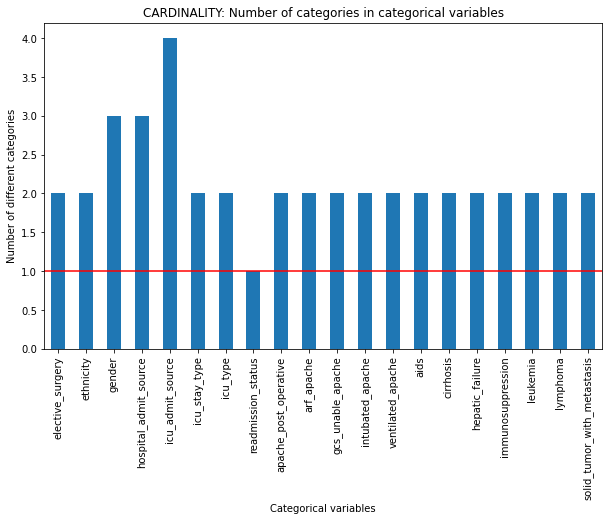

In [32]:

fig = group_rare[categorical].nunique().plot.bar(figsize=(10,6))
# plot a threshold of categories that has only one sub-category
fig.axhline(y=1, color='red')
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

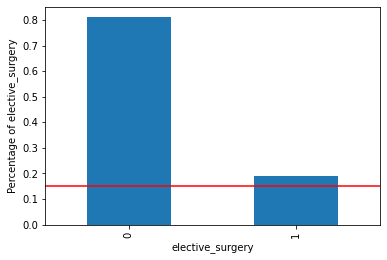

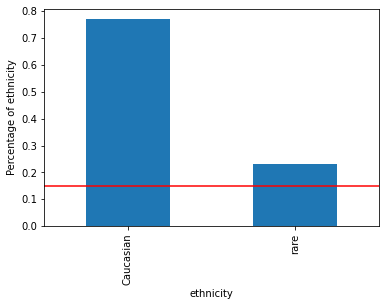

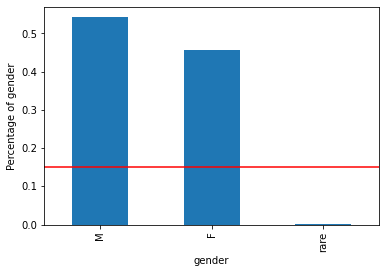

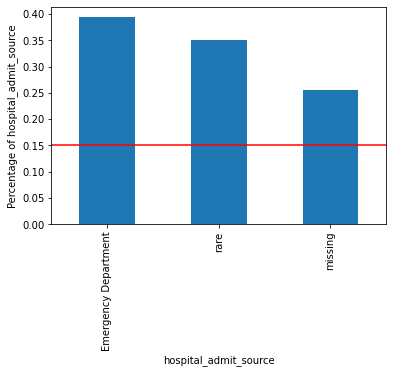

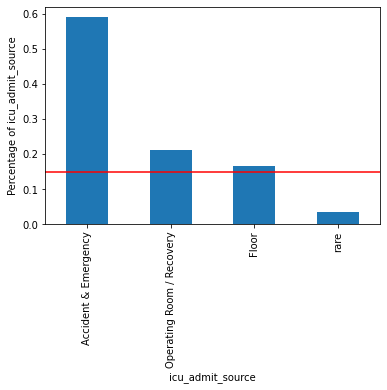

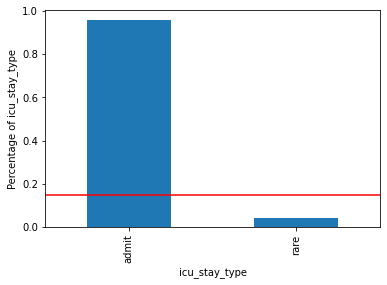

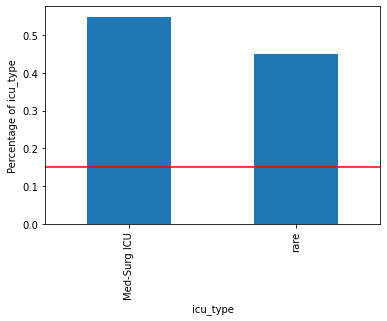

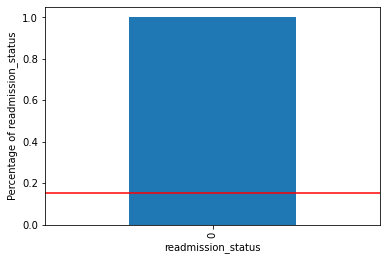

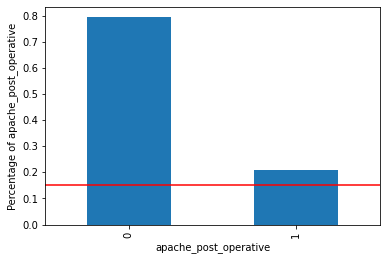

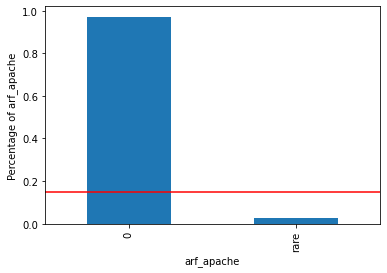

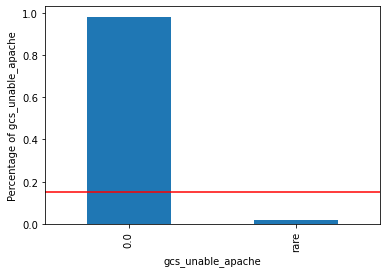

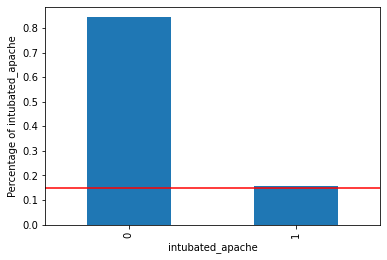

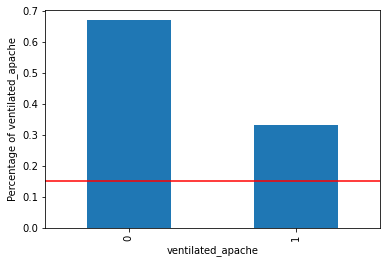

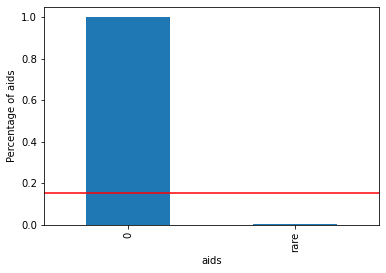

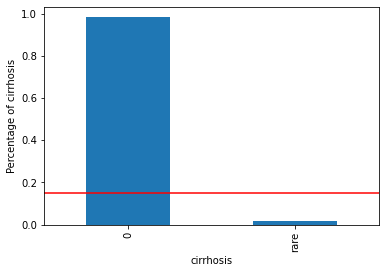

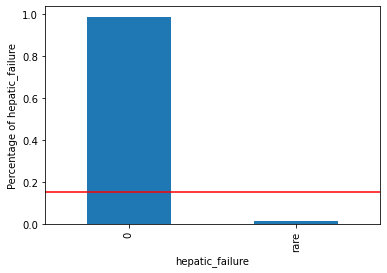

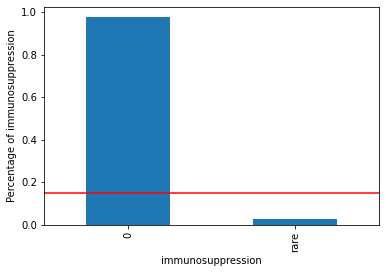

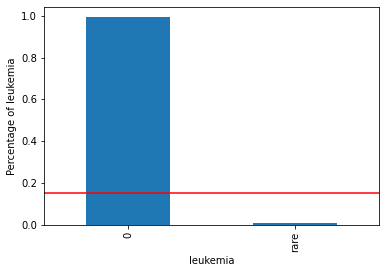

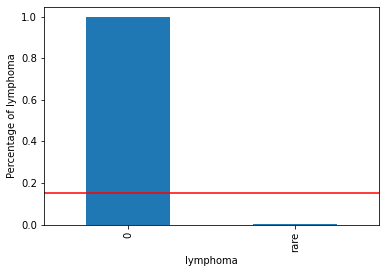

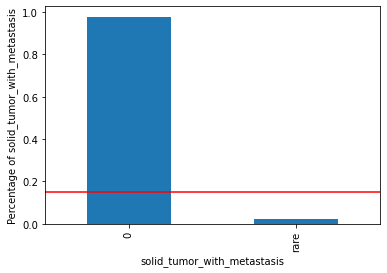

In [33]:
total_labels = len(group_rare)

# for each categorical variable
for col in categorical:

    temp_df = pd.Series(group_rare[col].value_counts() / total_labels)

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.15, color='red')
    fig.set_ylabel(f'Percentage of {col}')
    plt.show()

In [34]:
# Number of unique classes in each object column
group_rare[categorical].apply(pd.Series.nunique, axis = 0)

elective_surgery               2
ethnicity                      2
gender                         3
hospital_admit_source          3
icu_admit_source               4
icu_stay_type                  2
icu_type                       2
readmission_status             1
apache_post_operative          2
arf_apache                     2
gcs_unable_apache              2
intubated_apache               2
ventilated_apache              2
aids                           2
cirrhosis                      2
hepatic_failure                2
immunosuppression              2
leukemia                       2
lymphoma                       2
solid_tumor_with_metastasis    2
dtype: int64

--------
<hr>

# Encode categorical variables
I will use the WOE encoding to preserve a monotonic relationship with the target variable, as I am intended to logistic regression algorithm family. 
WOE has the benefit that it encode the categorical variables based on their good/bad events. 

<AxesSubplot:>

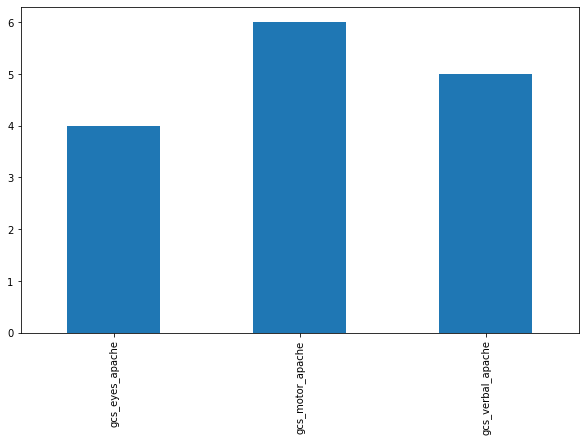

In [28]:
# plot number of categories per categorical variable

shallow_copy[discrete].nunique().plot.bar(figsize=(10,6))


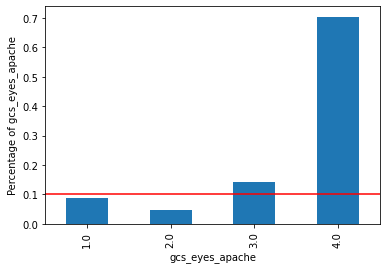

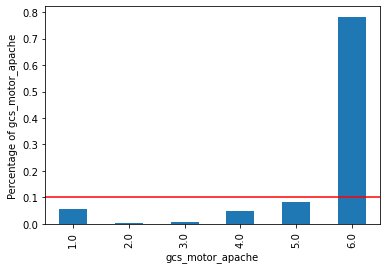

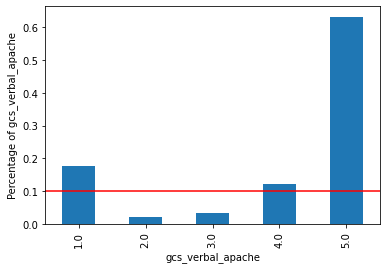

In [29]:
# for each categorical variable
for col in discrete:

    temp_df = pd.Series(shallow_copy[col].value_counts() / len(shallow_copy))

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.1, color='red')
    fig.set_ylabel(f'Percentage of {col}')
    plt.show()

In [30]:
# for each discrete variable
for col in discrete:
    shallow_copy[col] = group_rare_labels(shallow_copy, col, 0.1)

Convert all variables into categories that have a value of 2. remove vara that has 1 category and less than threshold. 

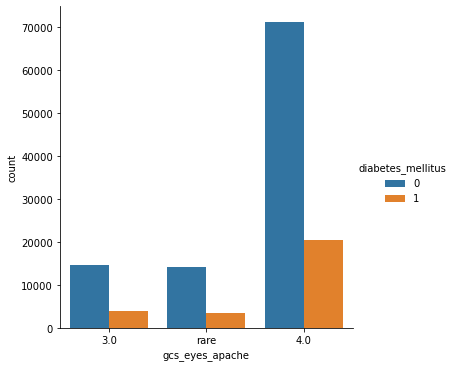

In [31]:
sns.catplot(data = shallow_copy, x = 'gcs_eyes_apache', kind='count', hue = 'diabetes_mellitus')

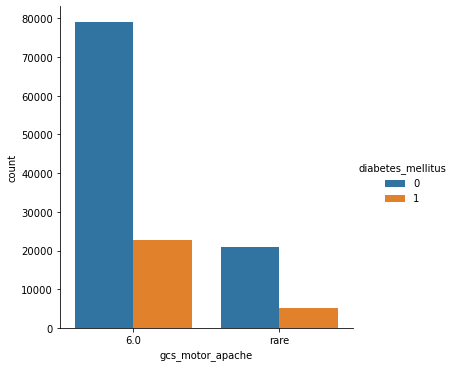

In [32]:
sns.catplot(data = shallow_copy, x = 'gcs_motor_apache', kind='count', hue = 'diabetes_mellitus')

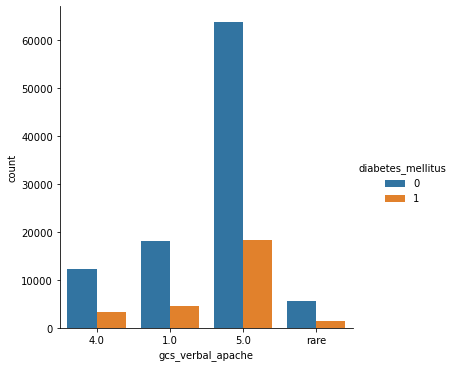

In [33]:
sns.catplot(data = shallow_copy, x = 'gcs_verbal_apache', kind='count', hue = 'diabetes_mellitus')

Drop `readmission_status`, `arf_apache`, 


-------
<hr>

# Numerical variables

Let's select the numerical and positive variables in the dataset for this demonstration. As most of the transformations require the variables to be positive.

In [34]:
# cols = []
# for col in X_train.columns:

#     if X_train[col].dtypes != 'object' and col != 'diabetes_mellitus':  # if the variable is numerical and not the target
        
#         if np.sum(np.where(X_train[col] <= 0, 1, 0)) == 0:  # if the variable is positive
        
#             cols.append(col)  # append variable to the list

# cols

<Figure size 1440x1440 with 0 Axes>

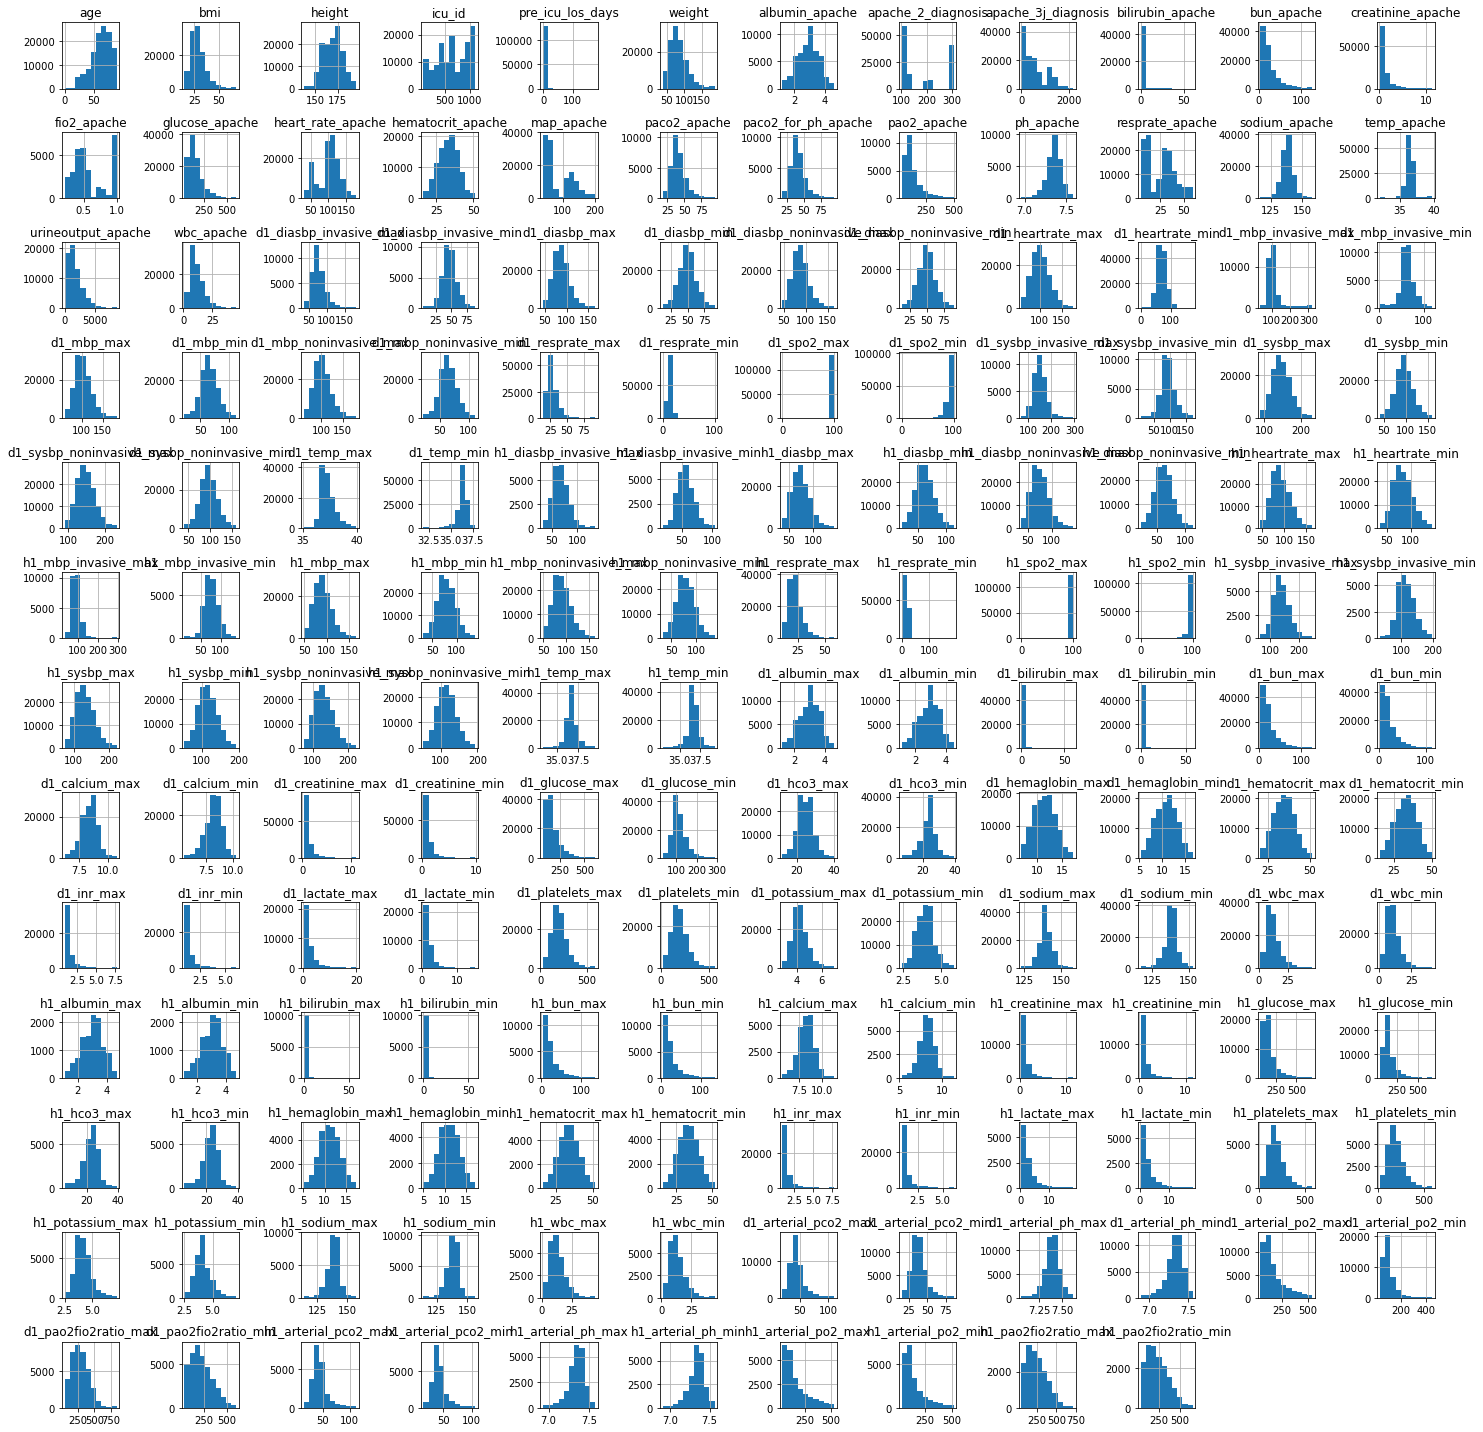

In [35]:

# let's explore the distribution of the numerical variables
fig = plt.figure(figsize = (20, 20))
shallow_copy[continuous].hist(figsize=(20,20))
plt.tight_layout()
plt.show()

To visualise the distribution of the variables, we plot a histogram and a Q-Q plot. In the Q-Q pLots, if the variable is normally distributed, the values of the variable should fall in a 45 degree line when plotted against the theoretical quantiles. We discussed this extensively in Section 3 of this course.

In [36]:
# # plot the histograms to have a quick look at the variable distribution
# # histogram and Q-Q plots

def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()


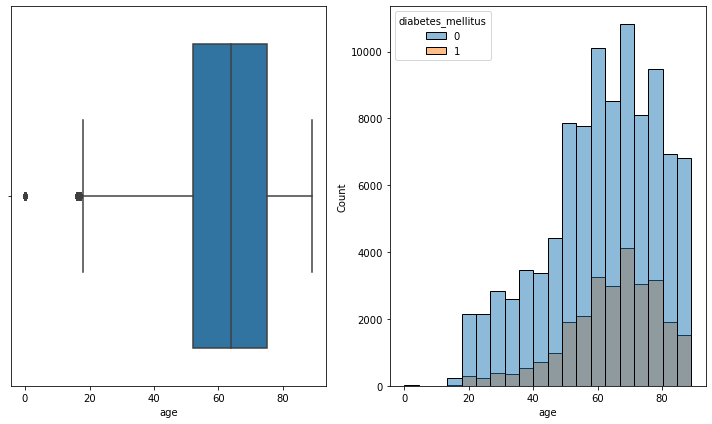

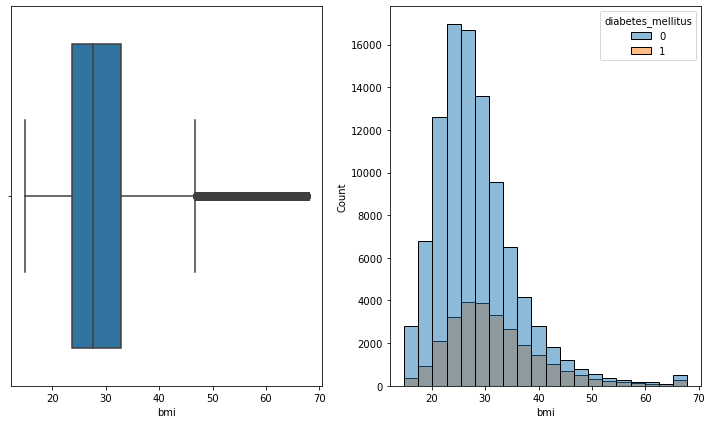

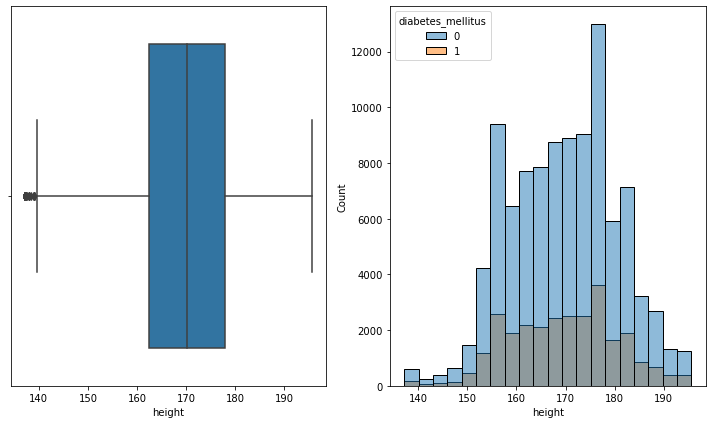

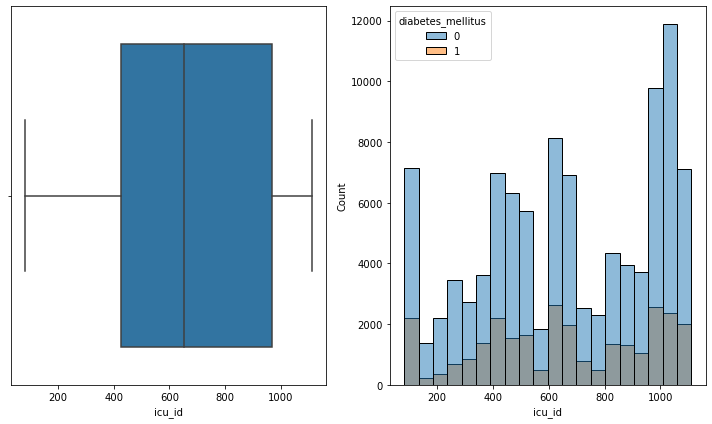

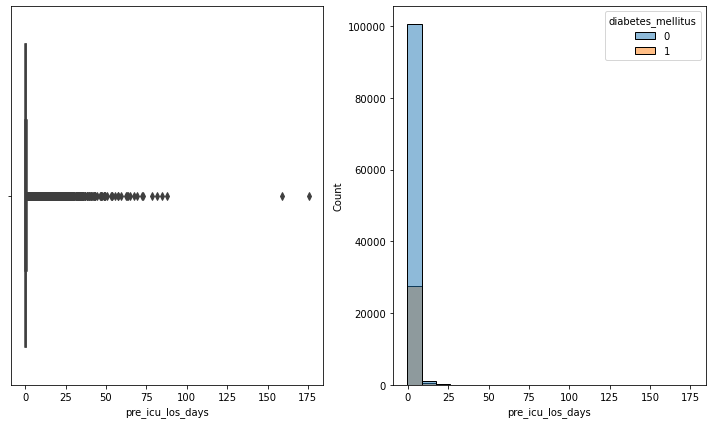

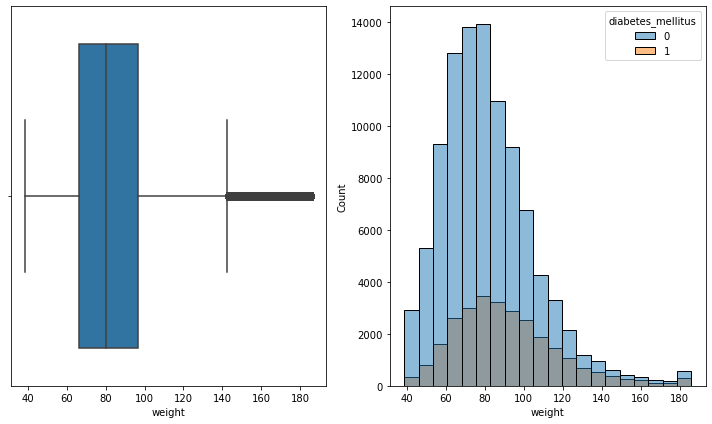

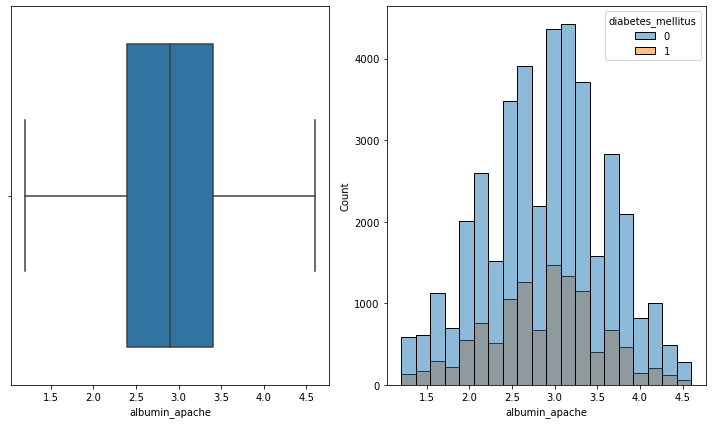

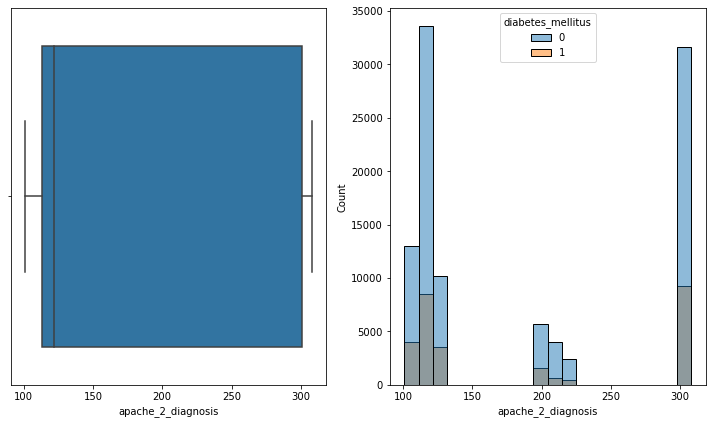

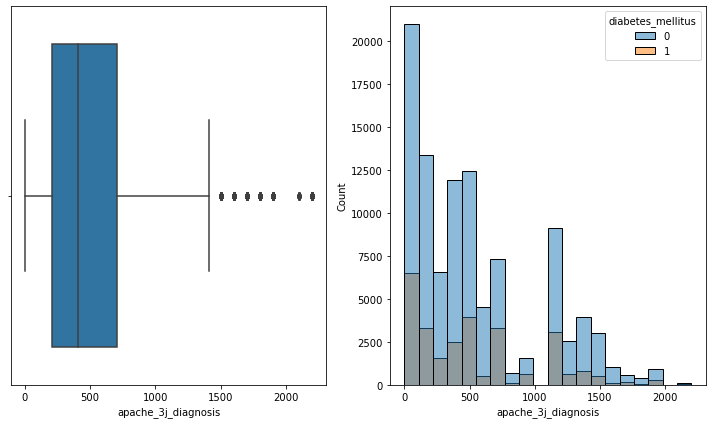

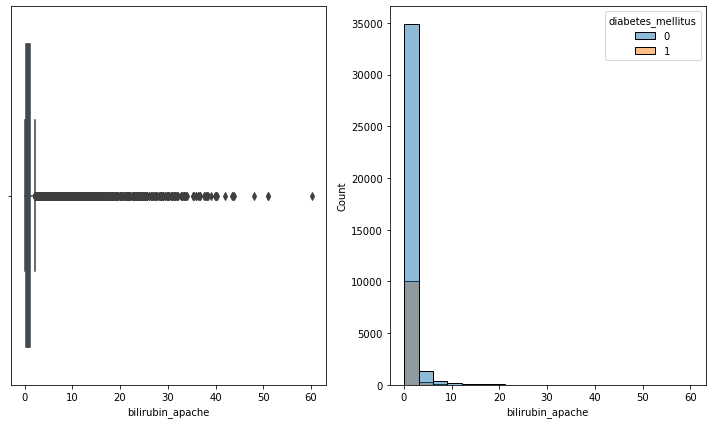

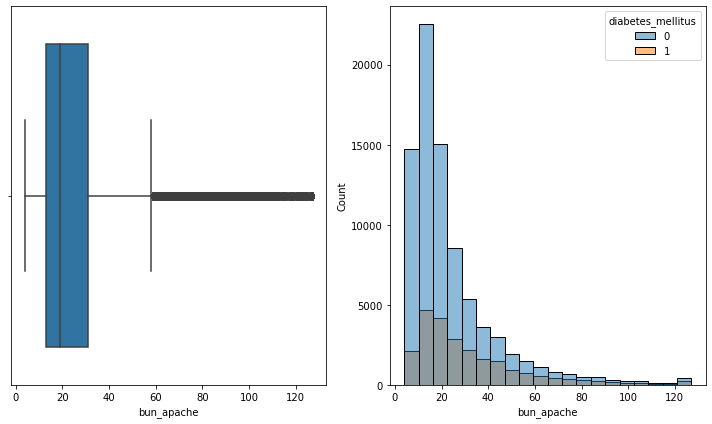

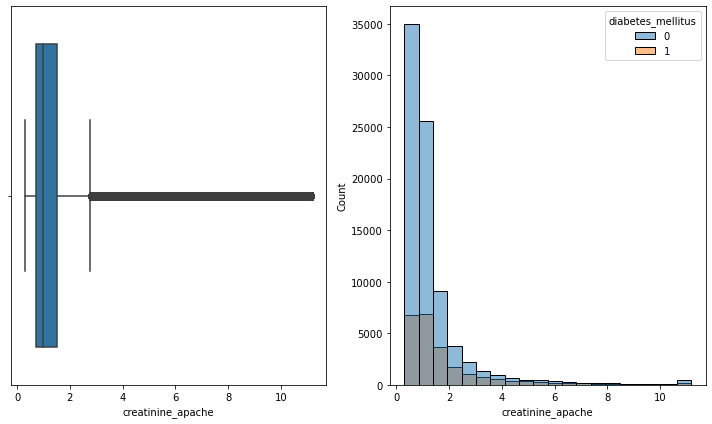

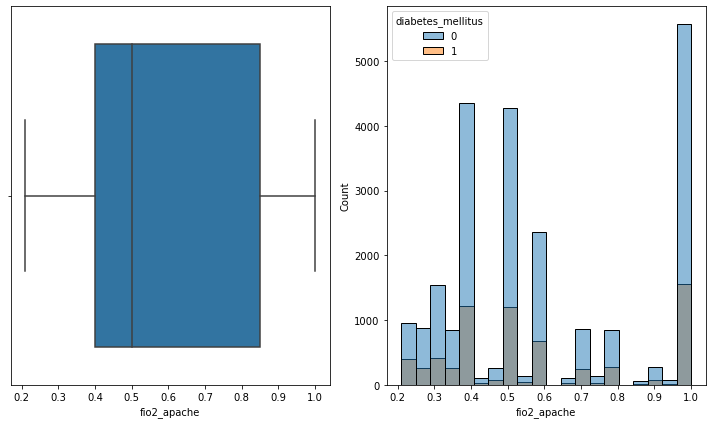

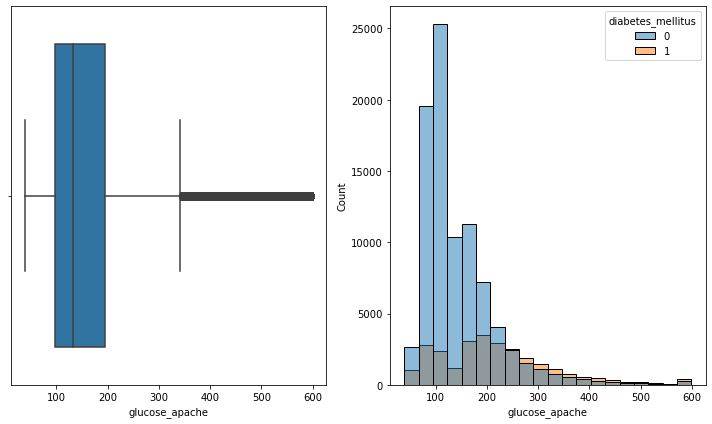

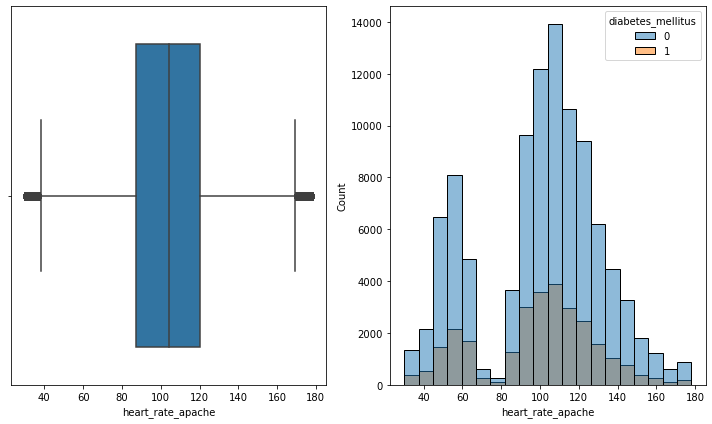

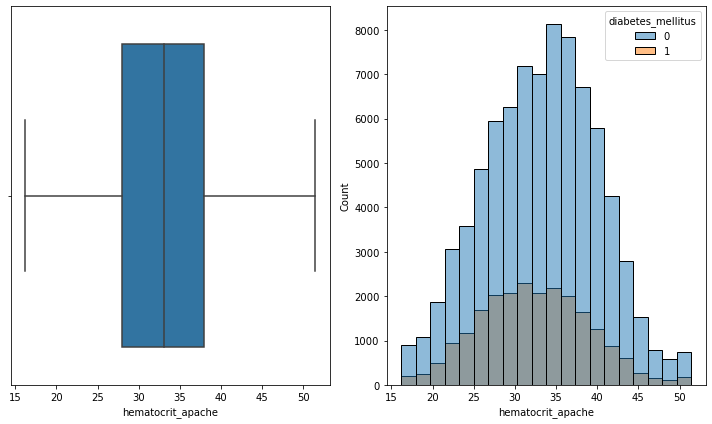

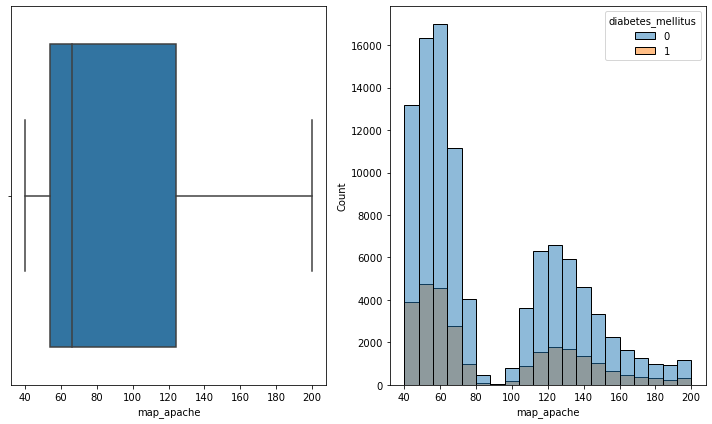

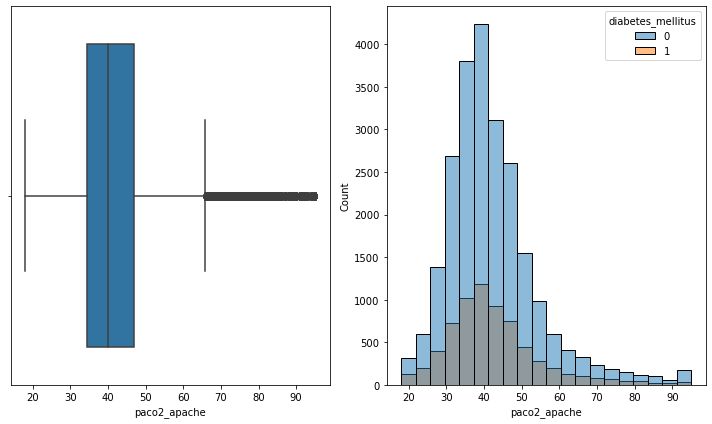

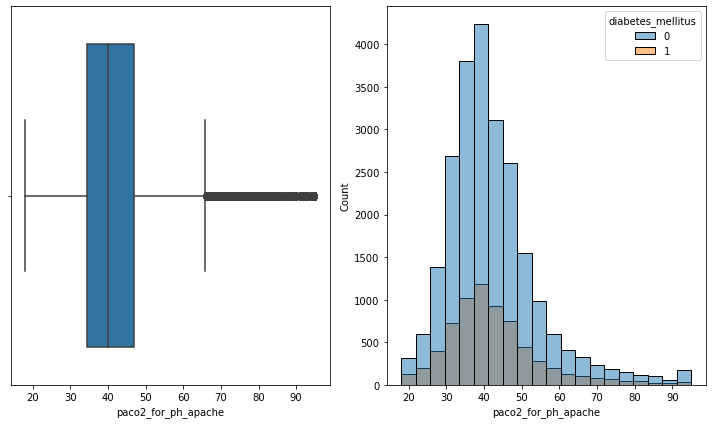

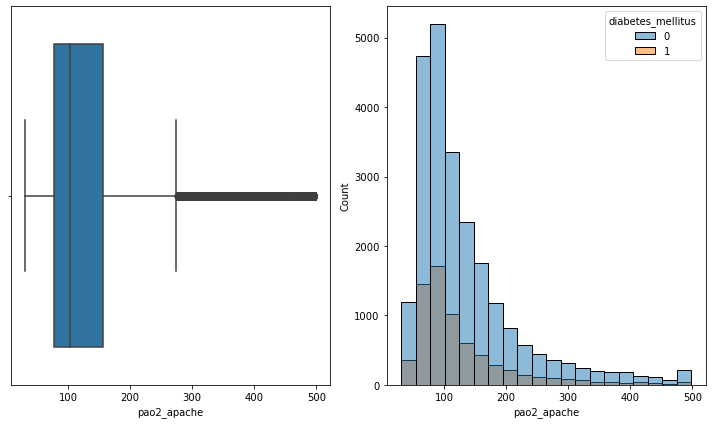

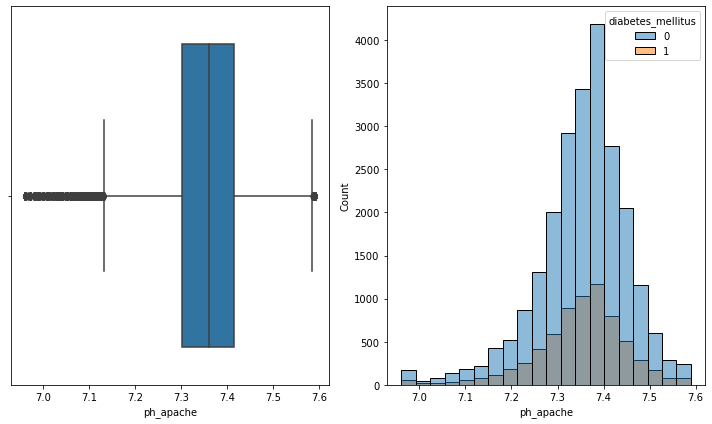

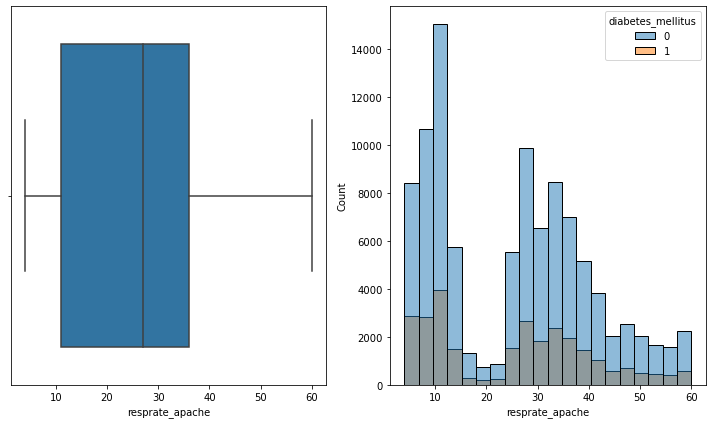

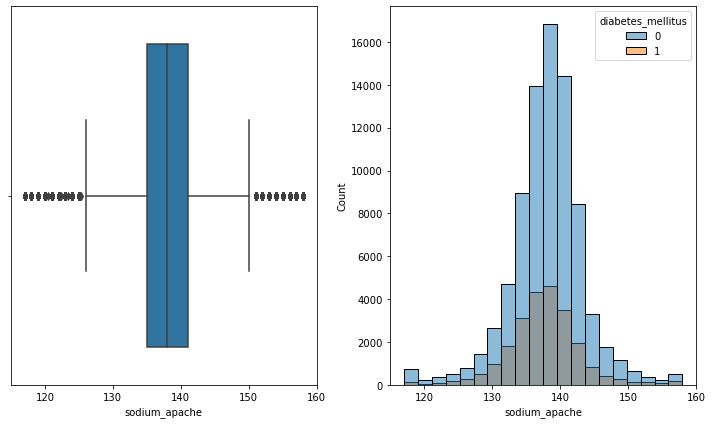

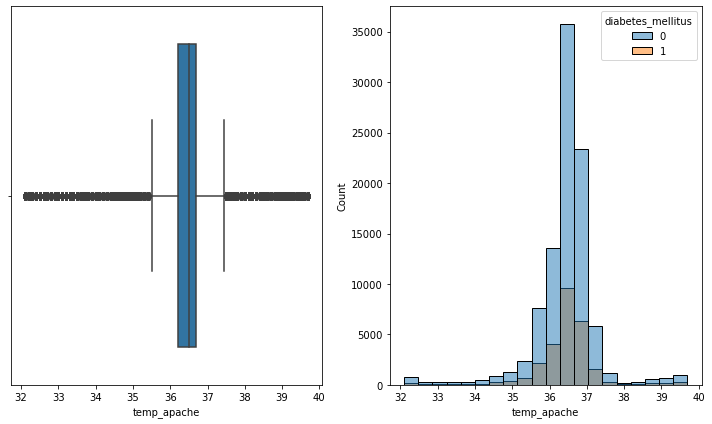

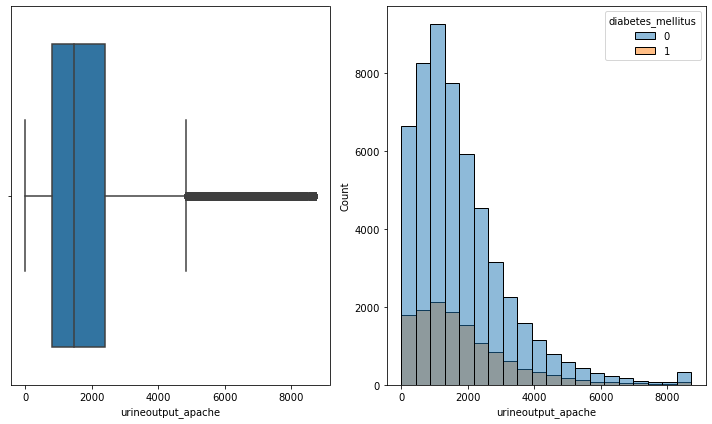

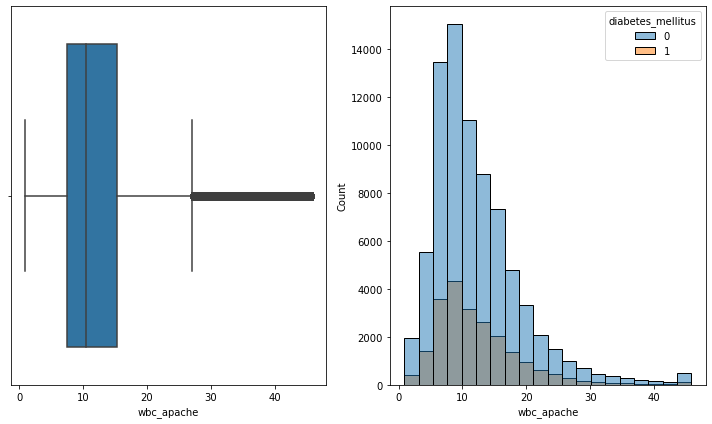

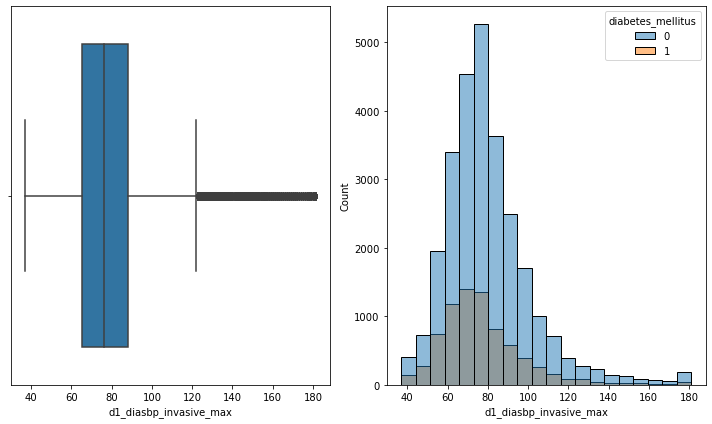

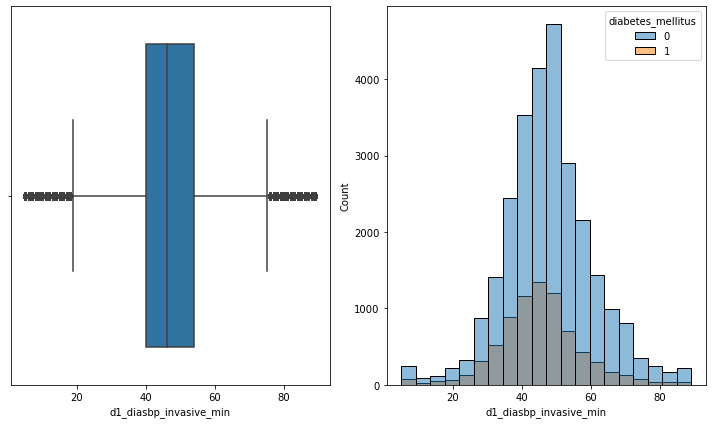

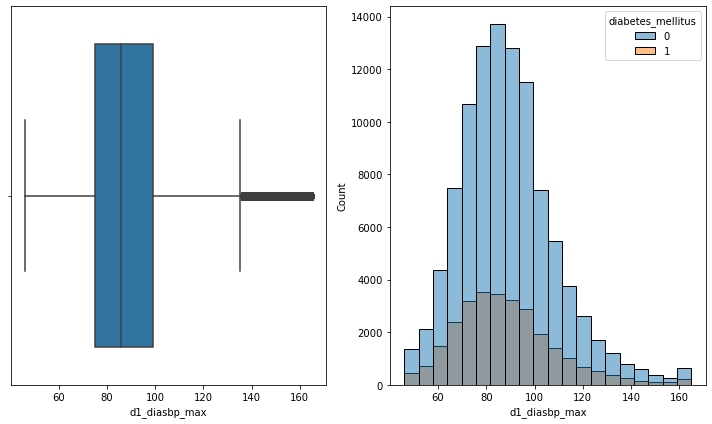

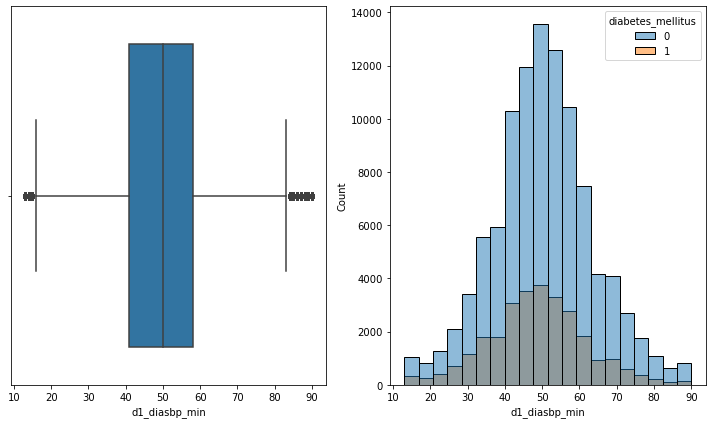

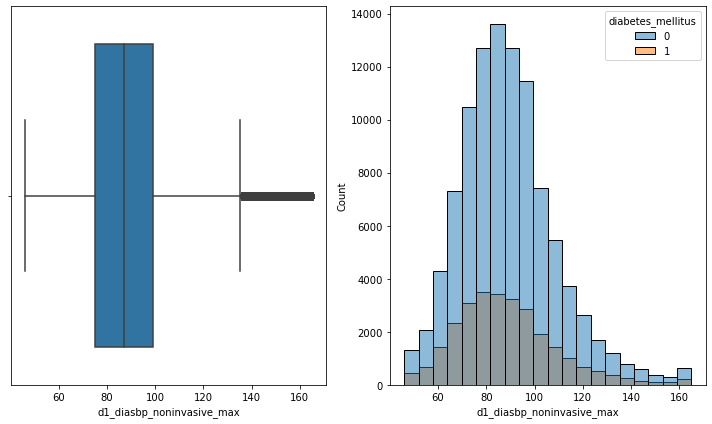

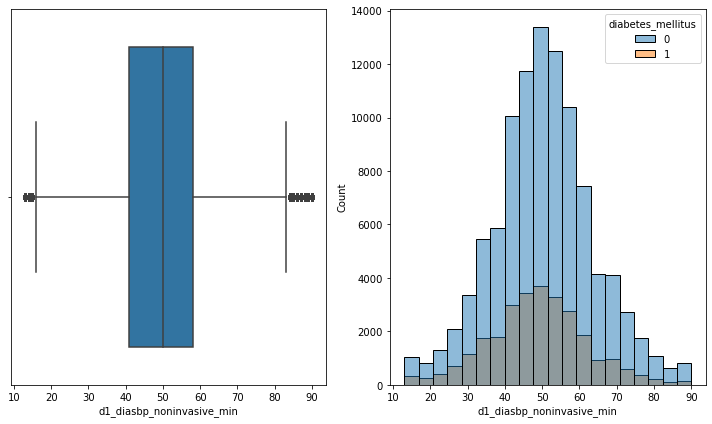

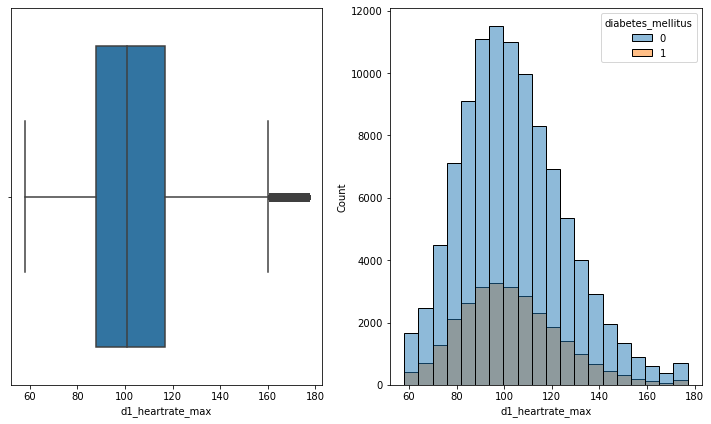

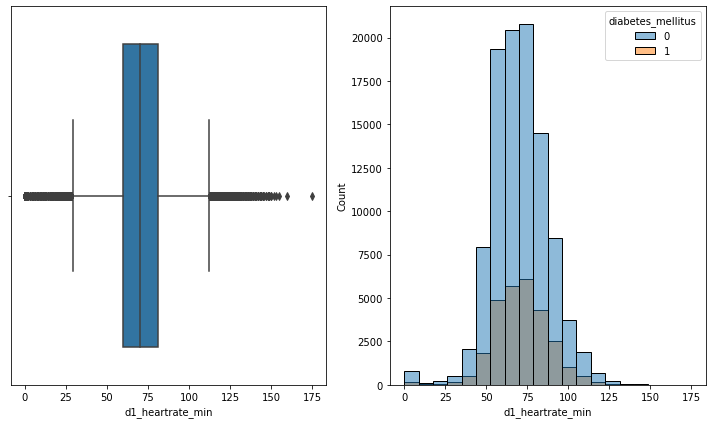

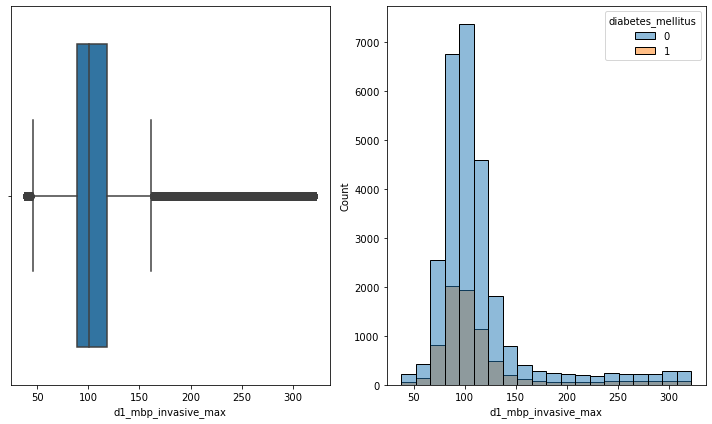

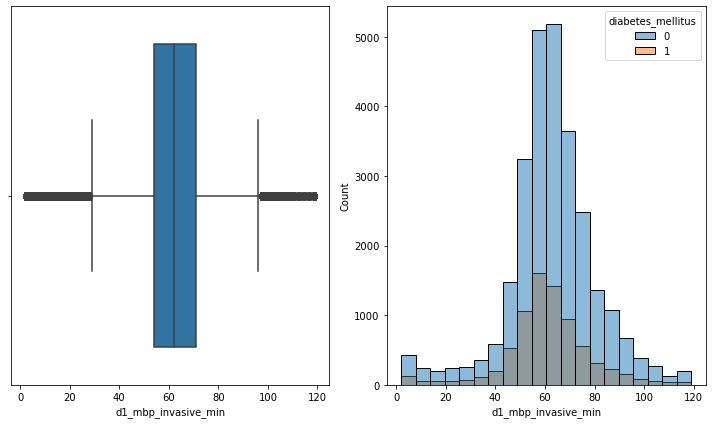

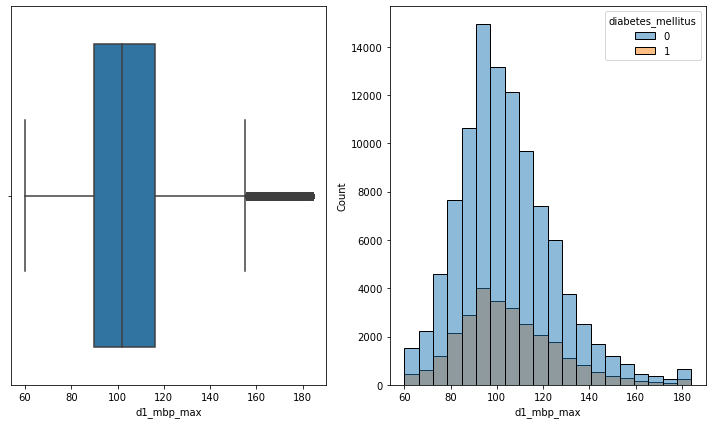

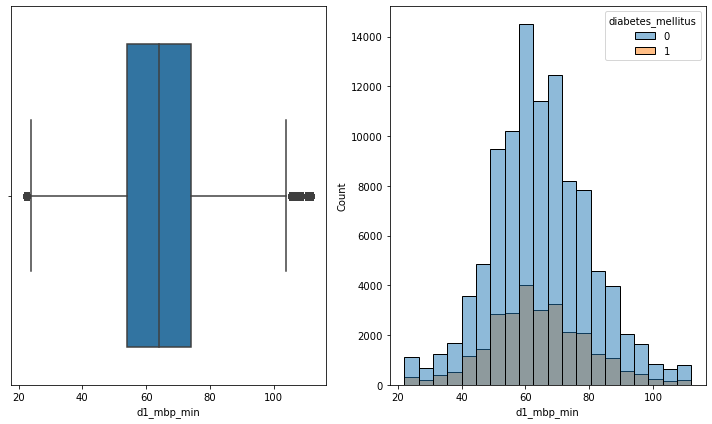

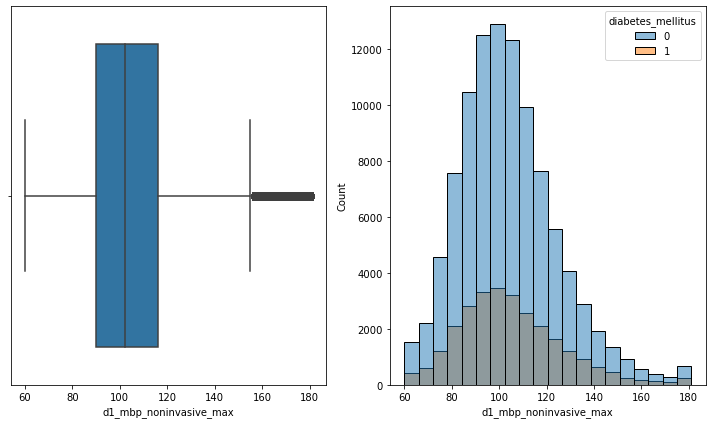

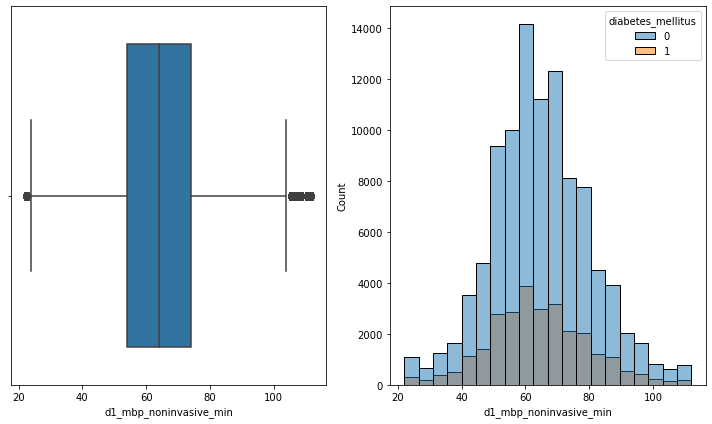

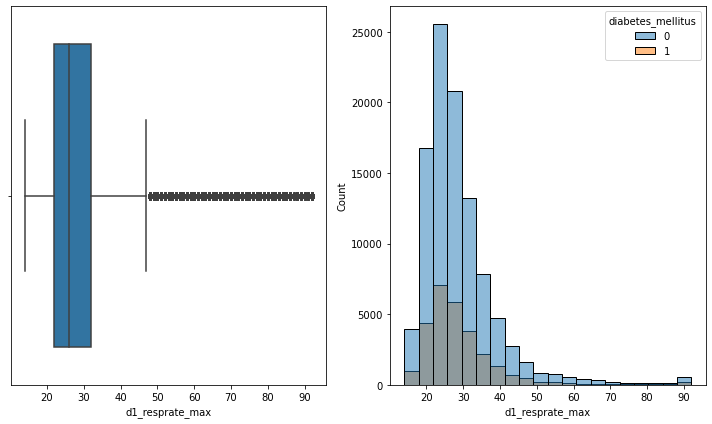

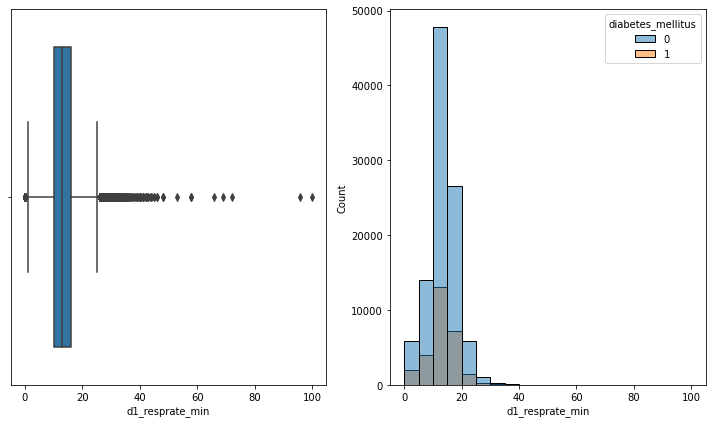

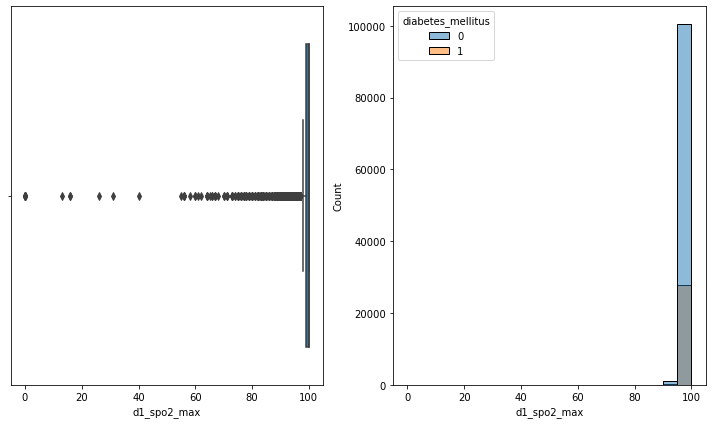

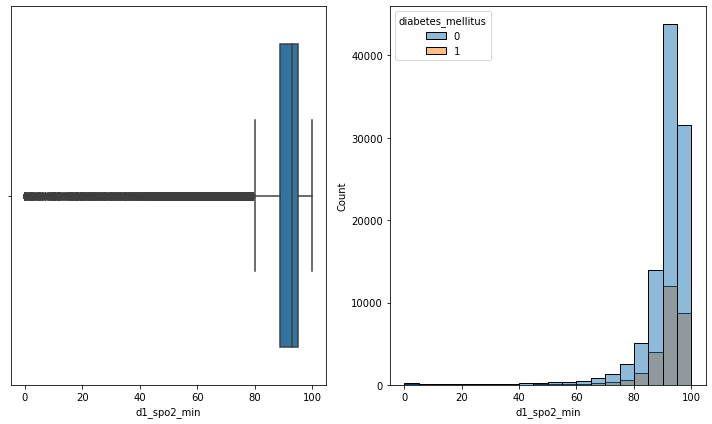

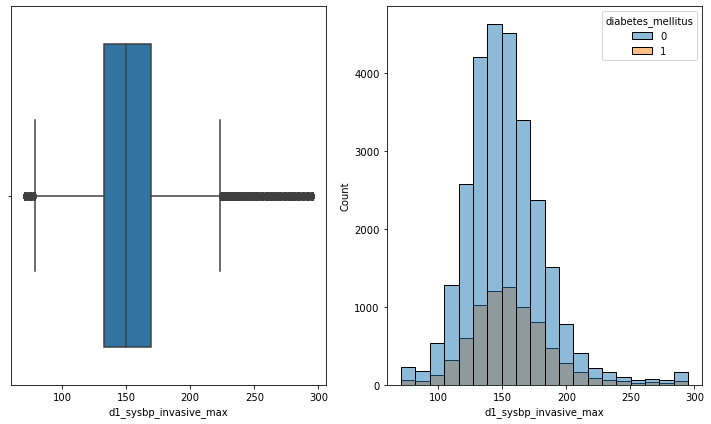

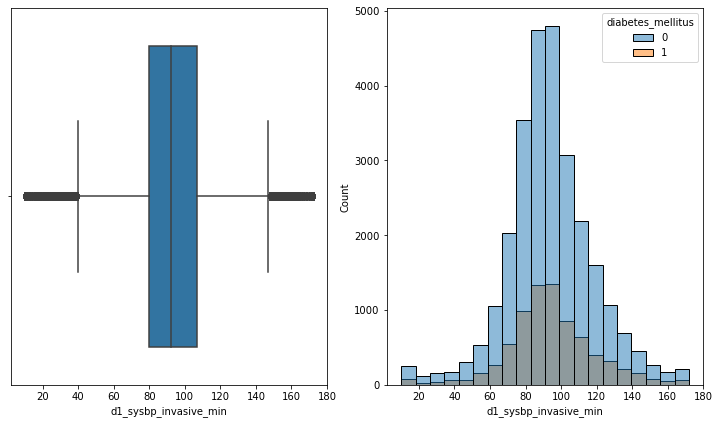

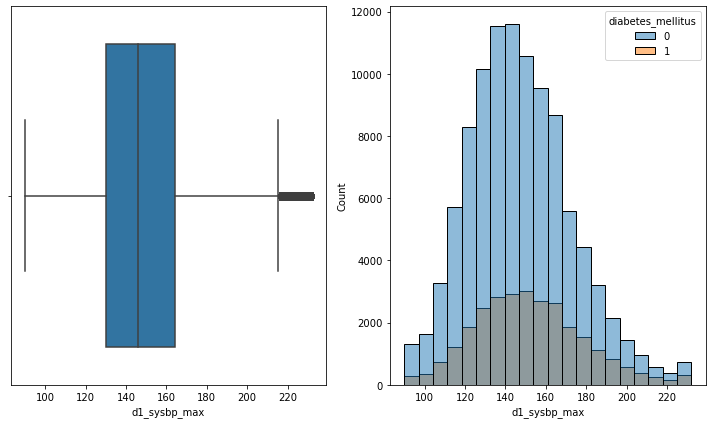

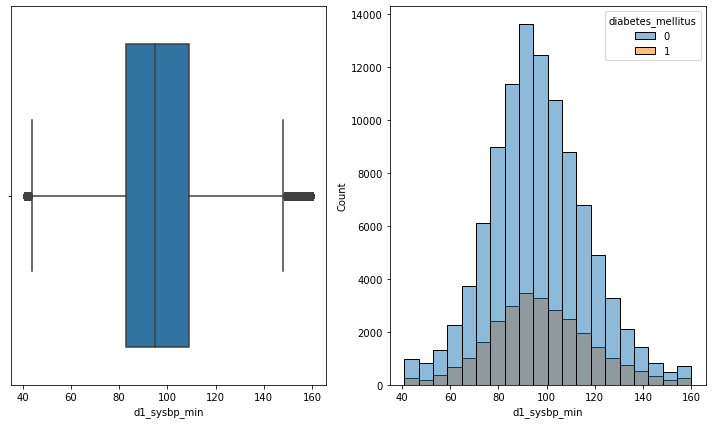

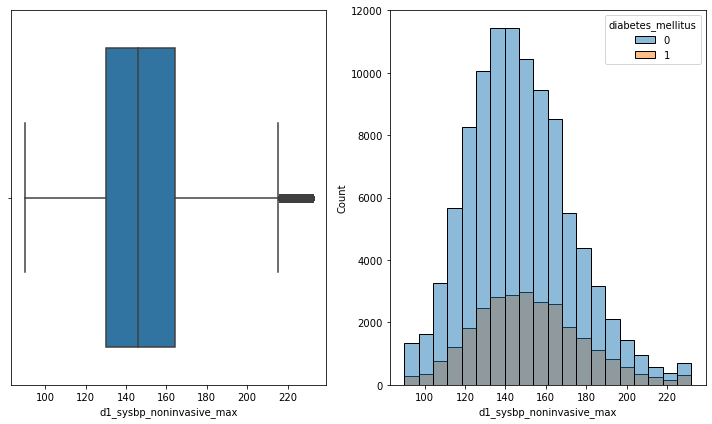

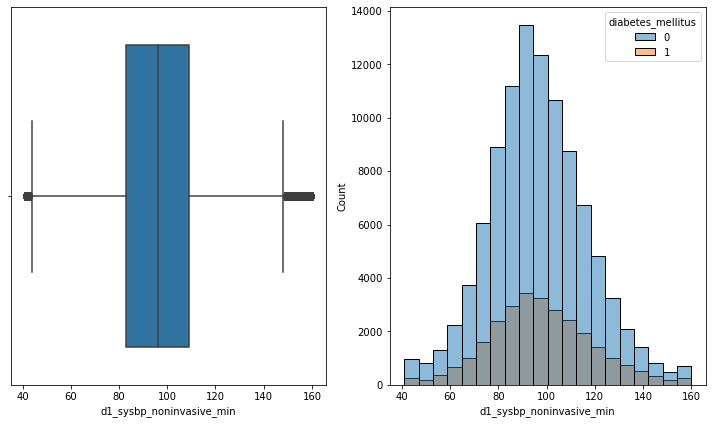

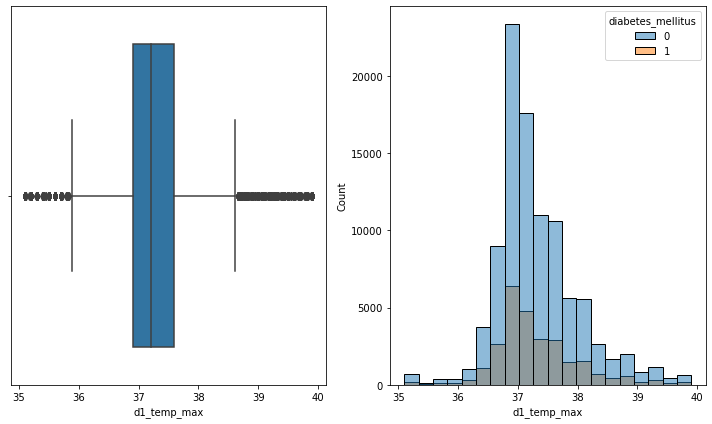

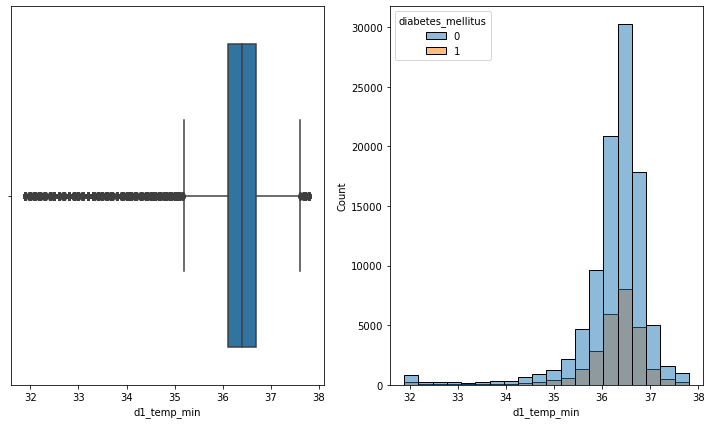

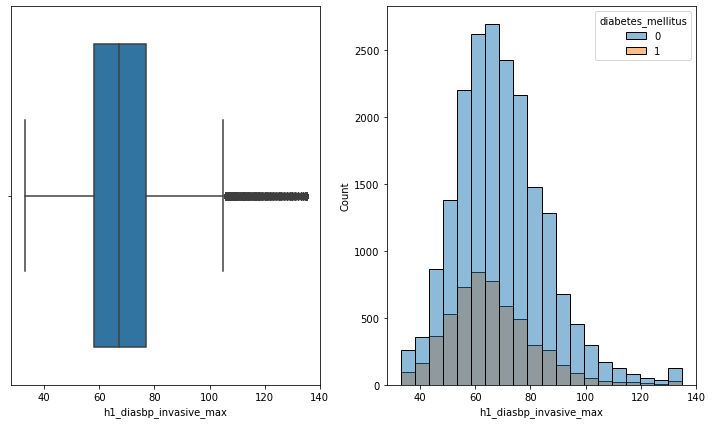

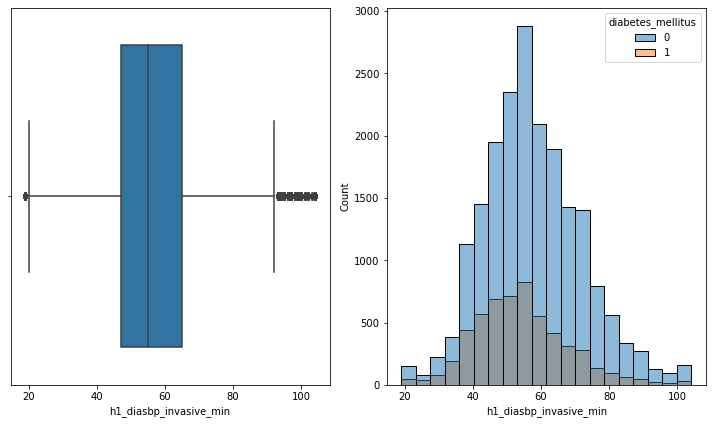

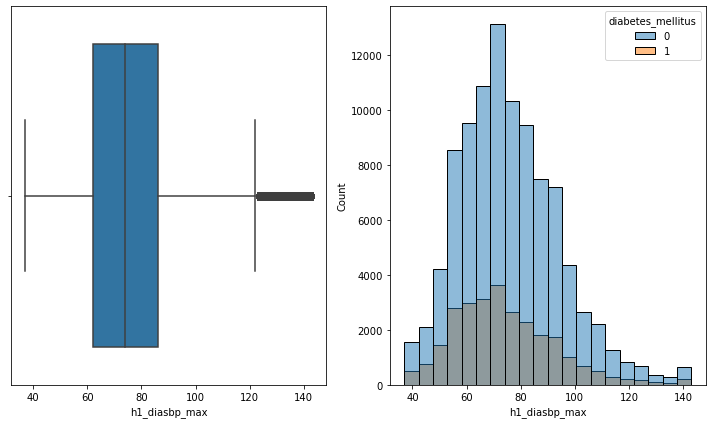

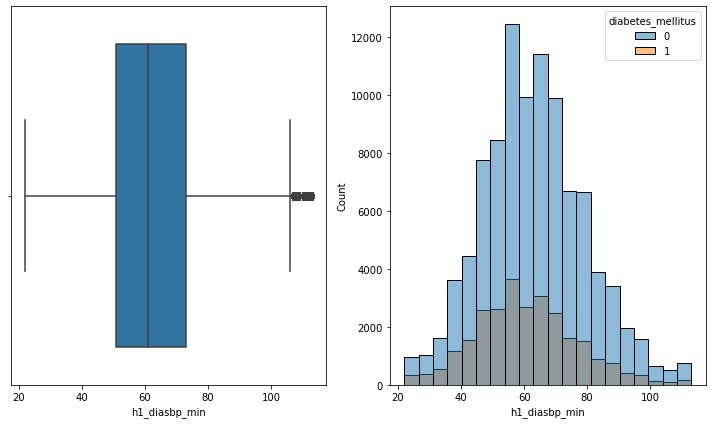

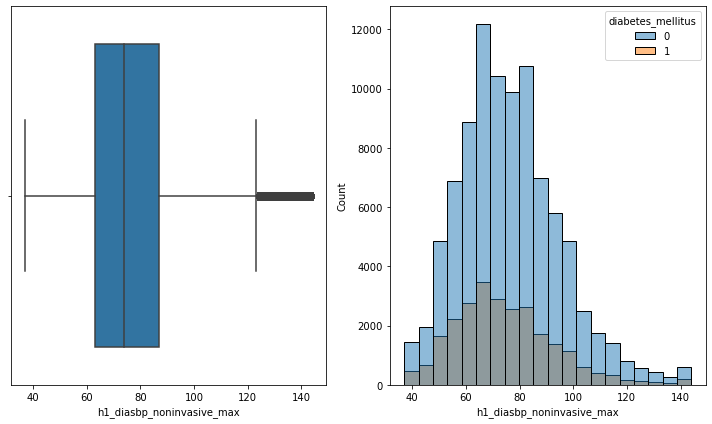

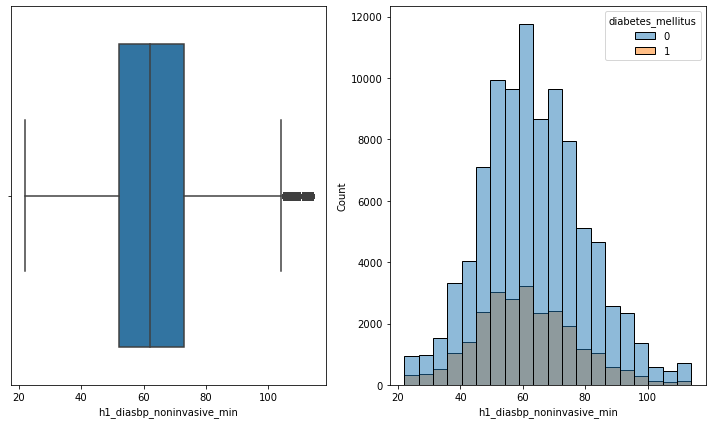

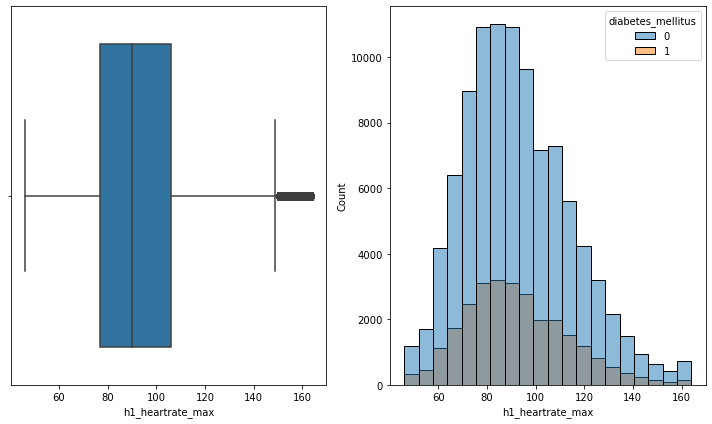

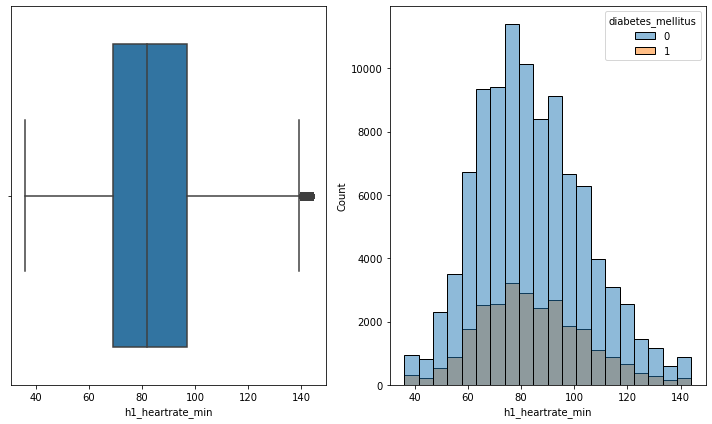

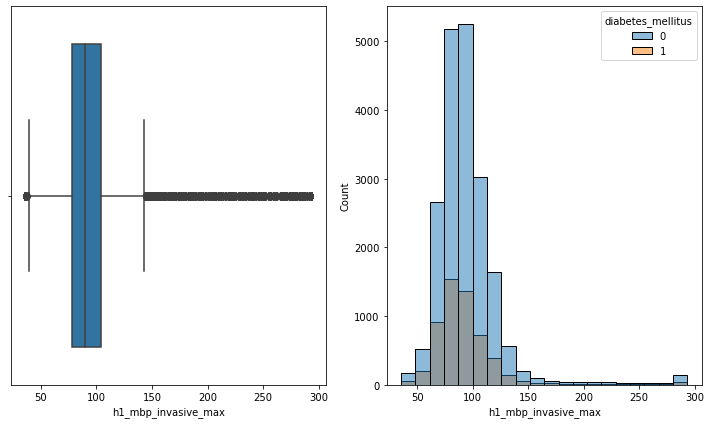

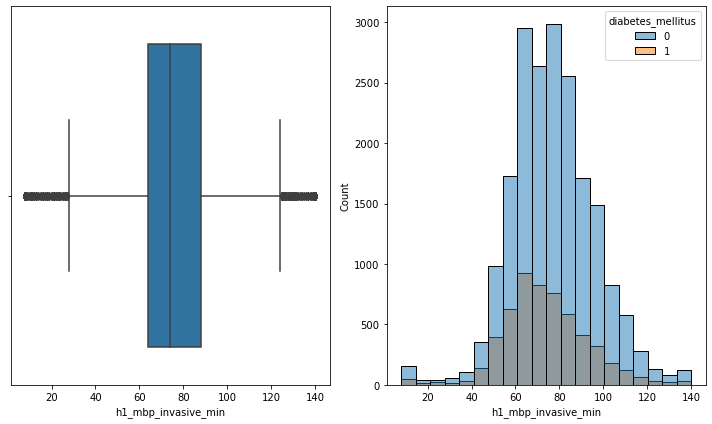

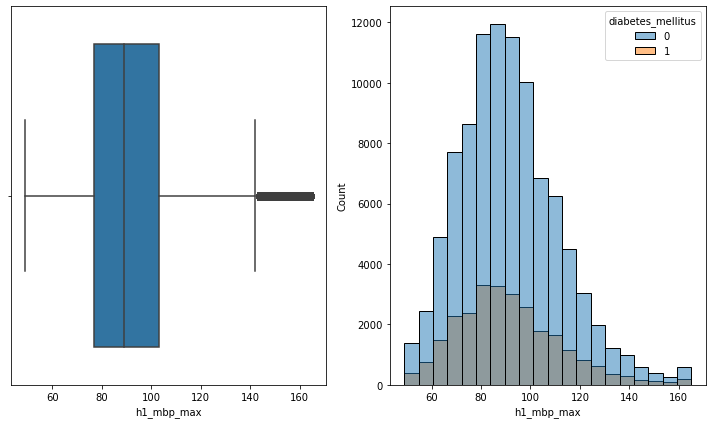

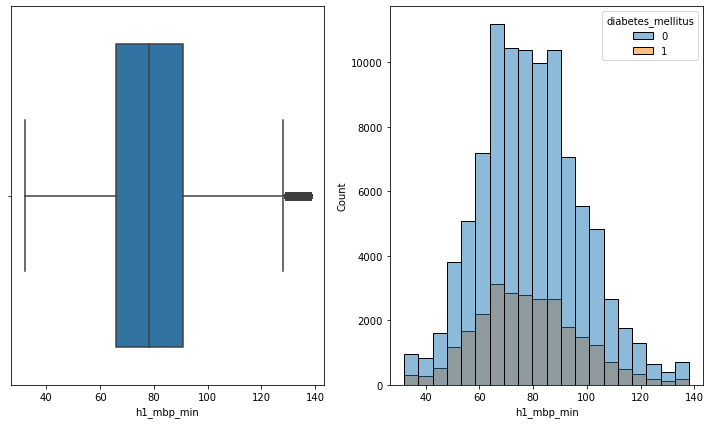

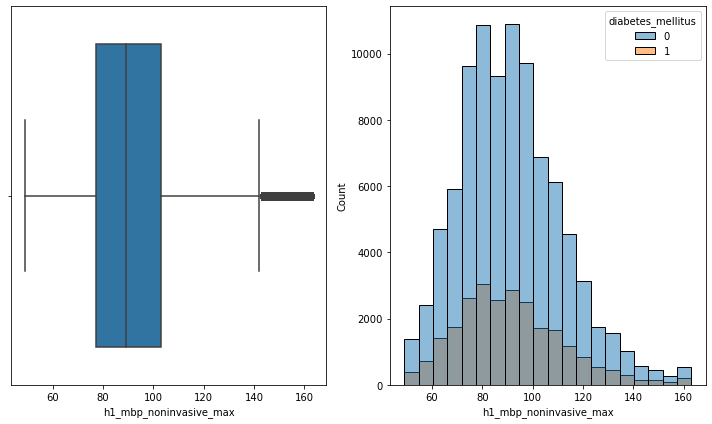

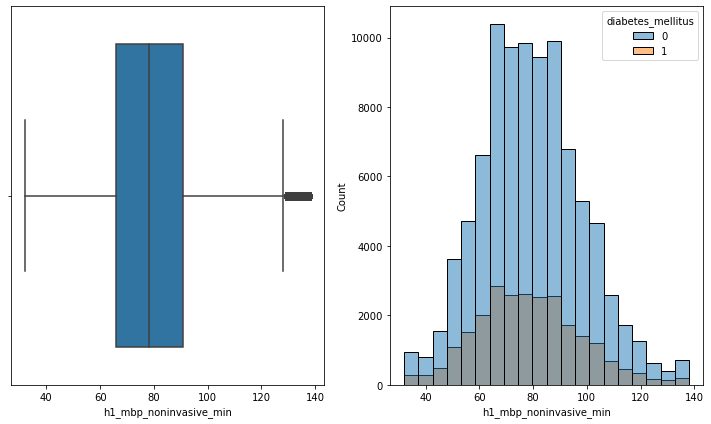

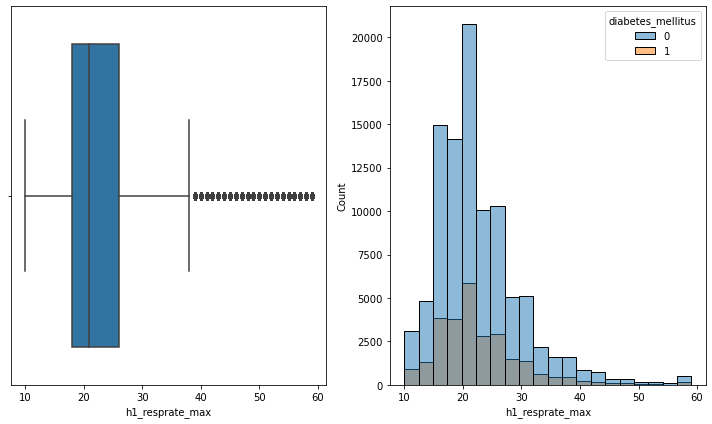

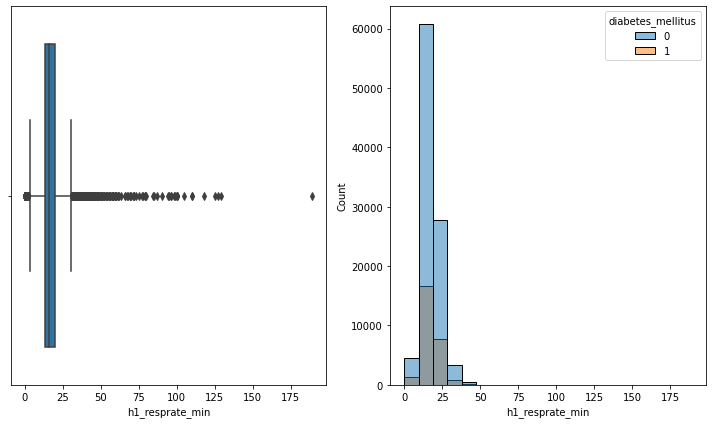

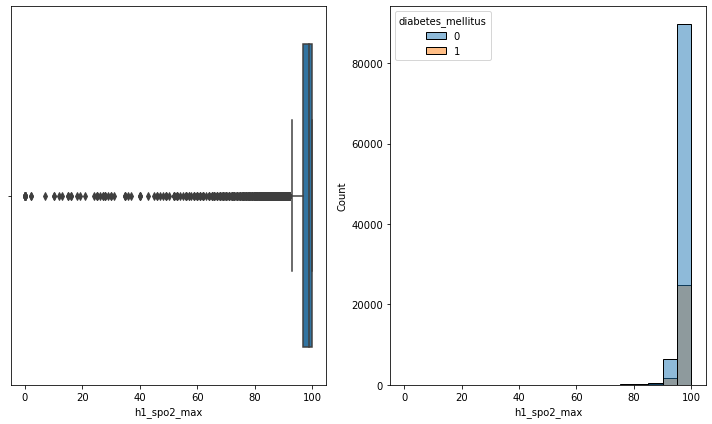

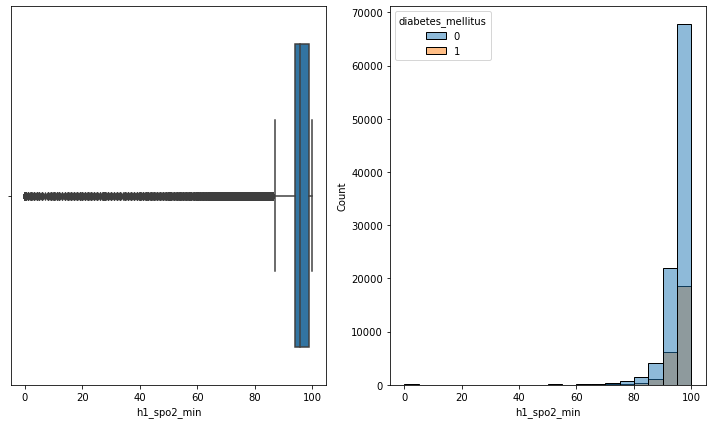

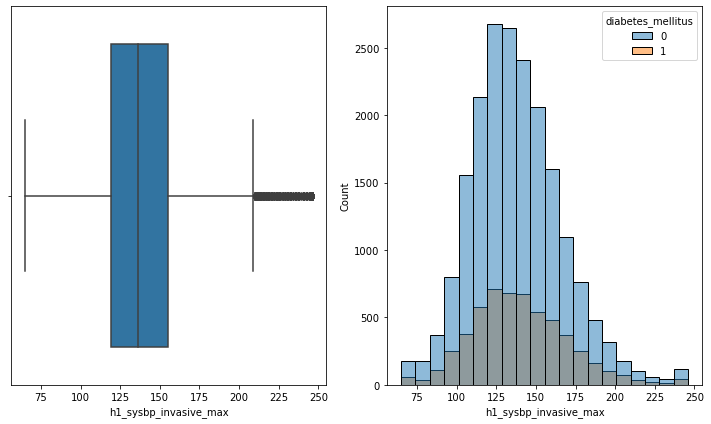

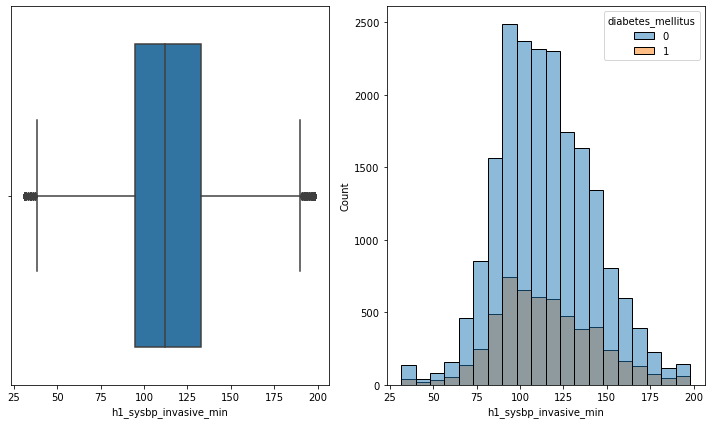

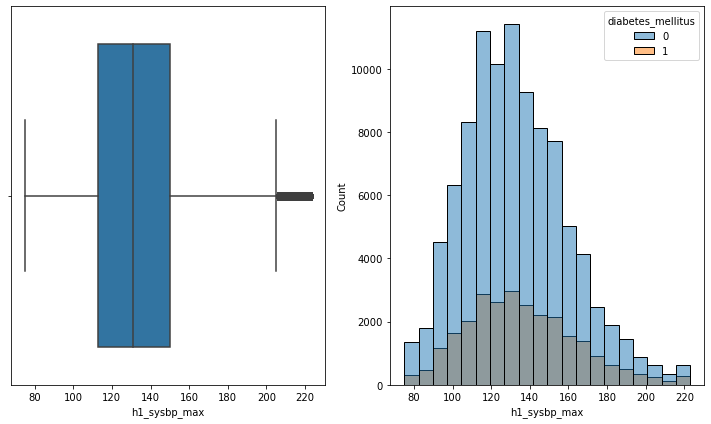

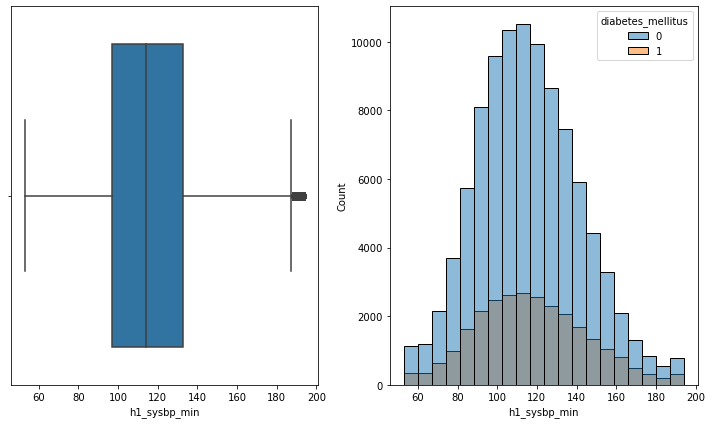

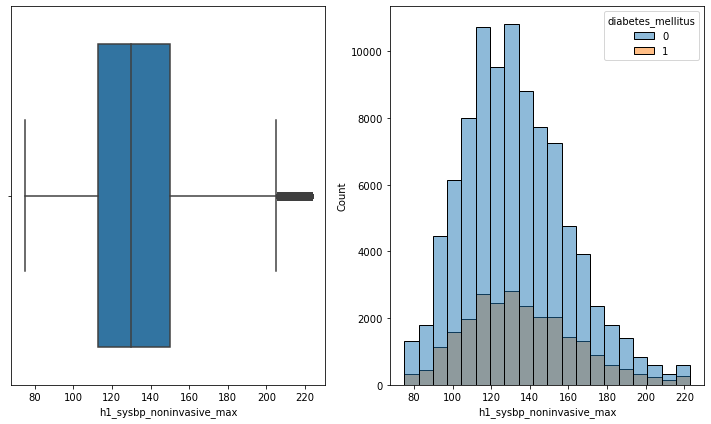

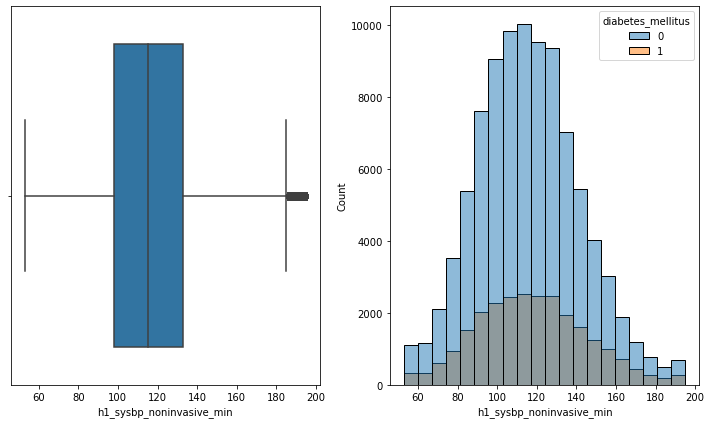

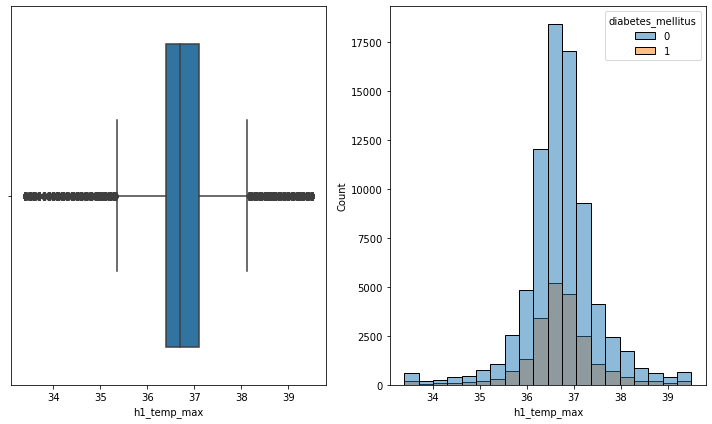

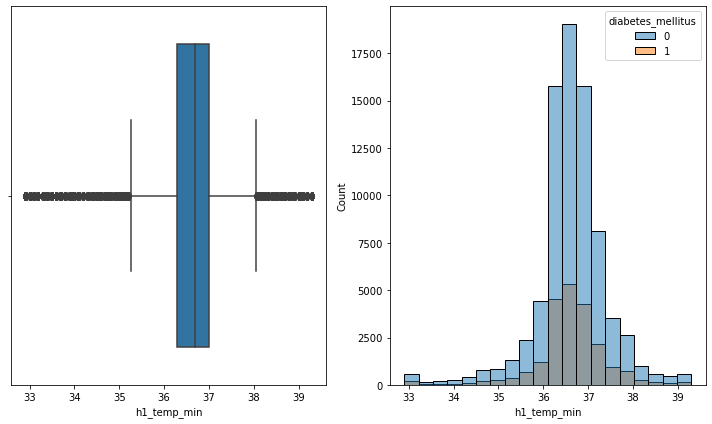

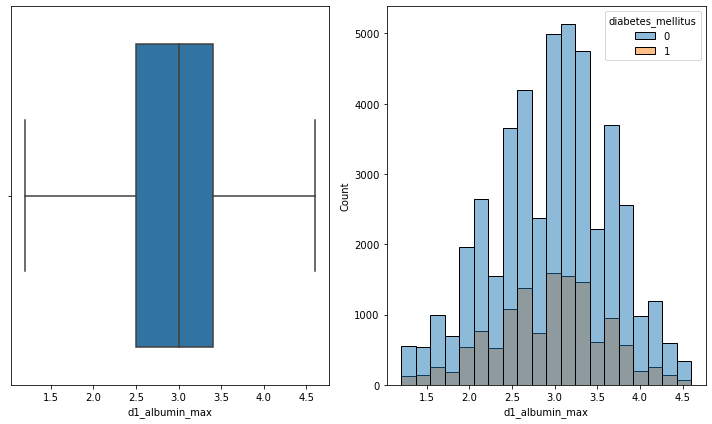

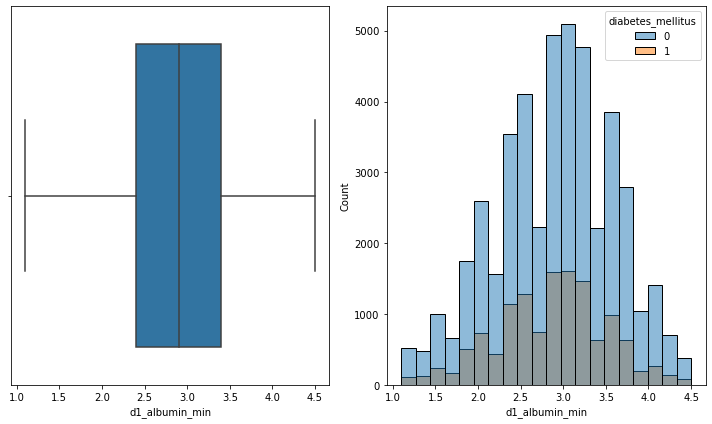

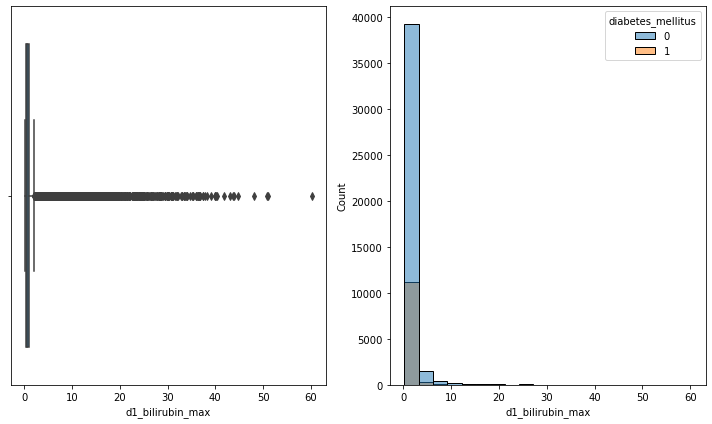

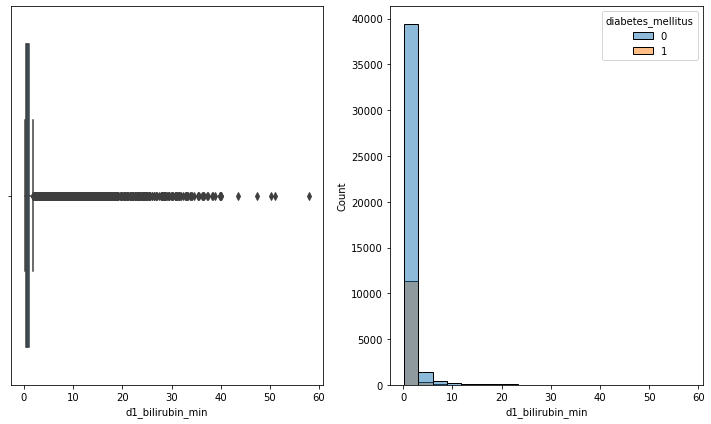

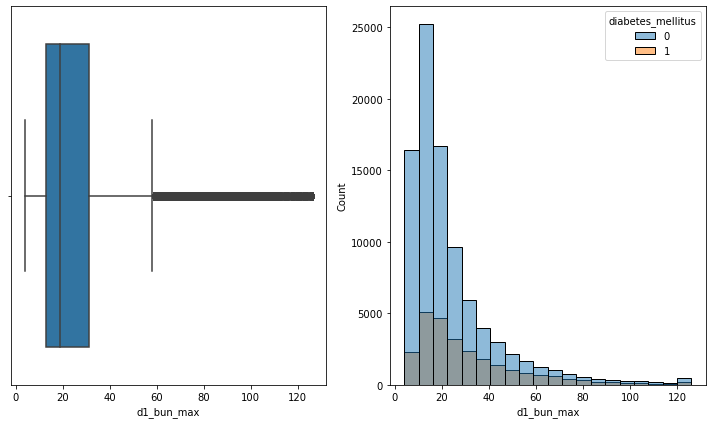

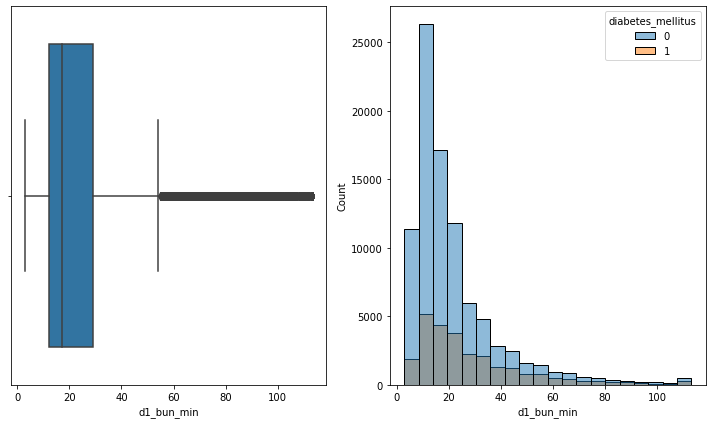

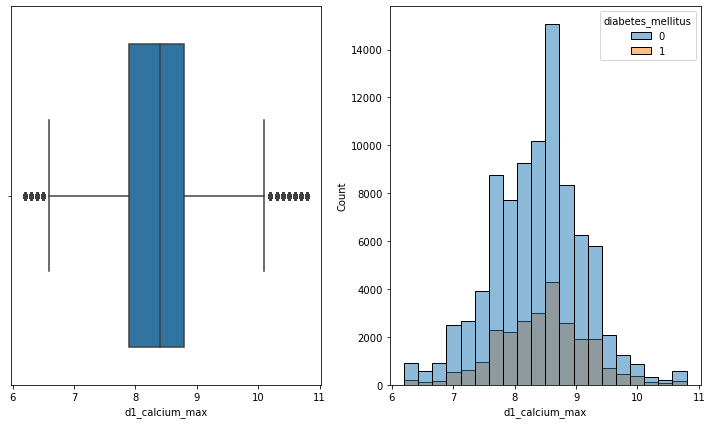

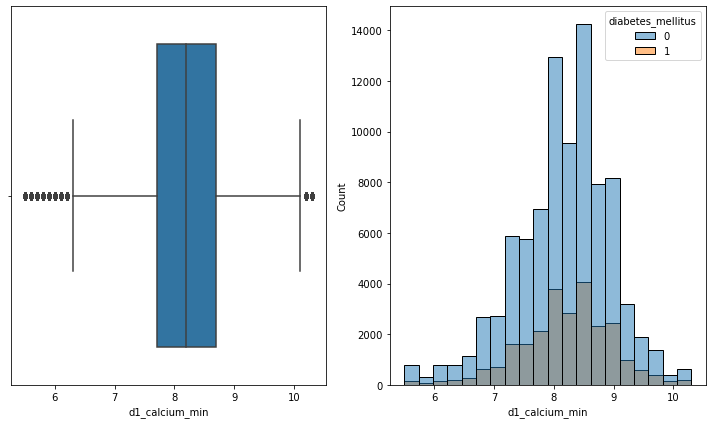

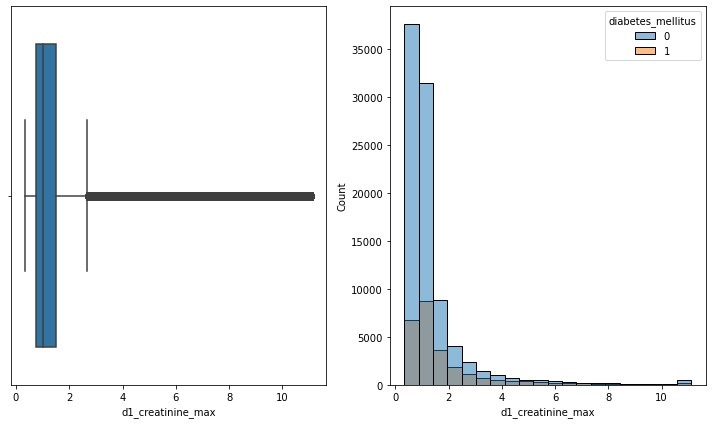

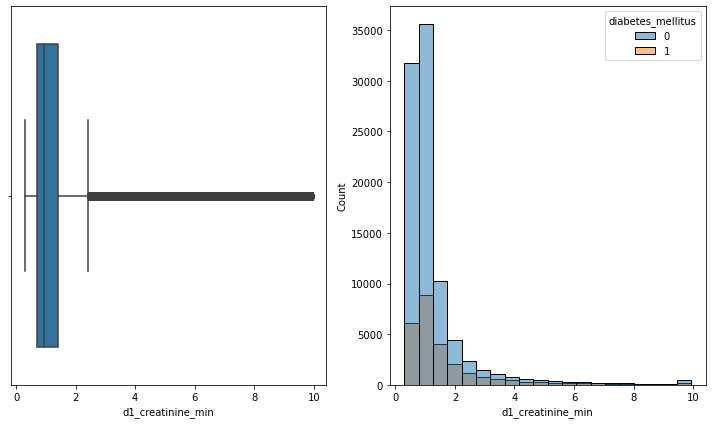

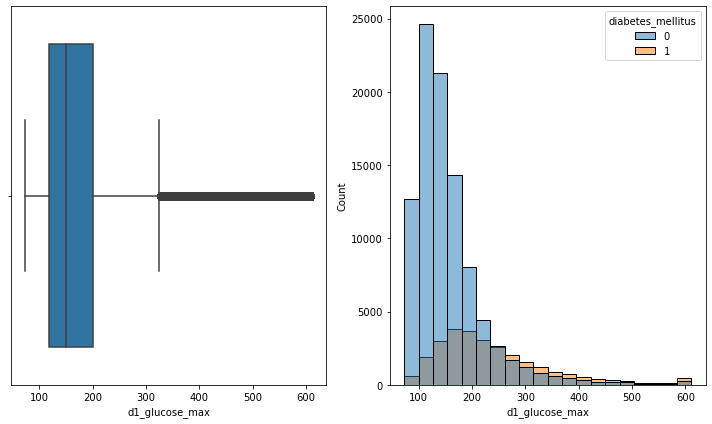

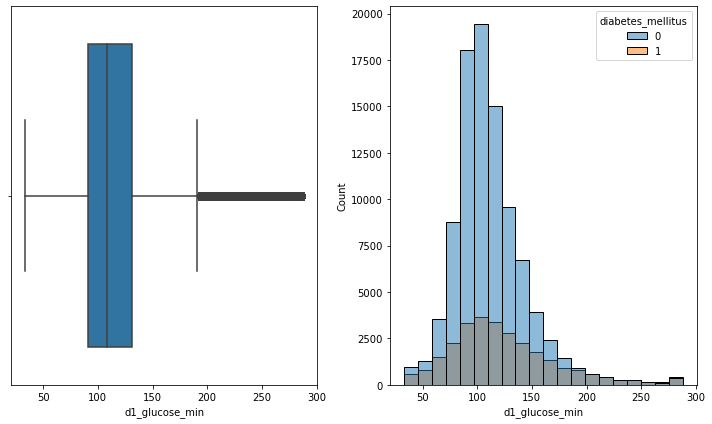

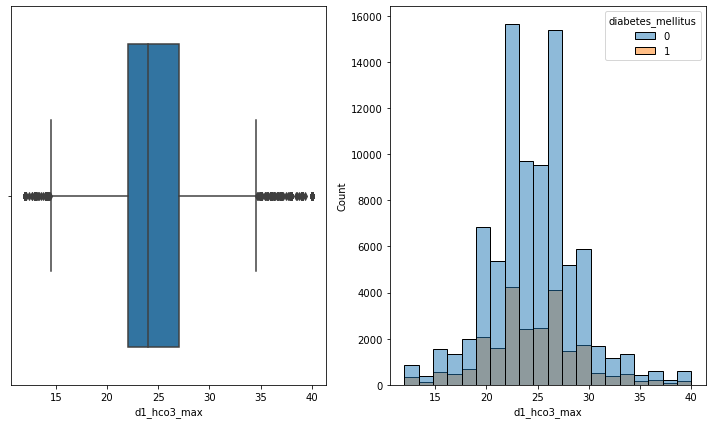

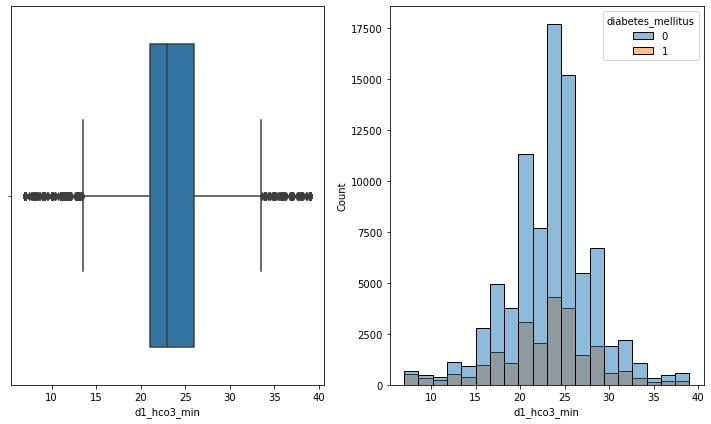

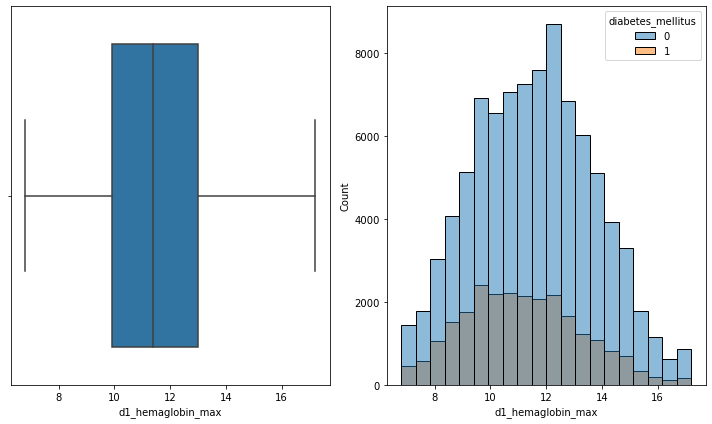

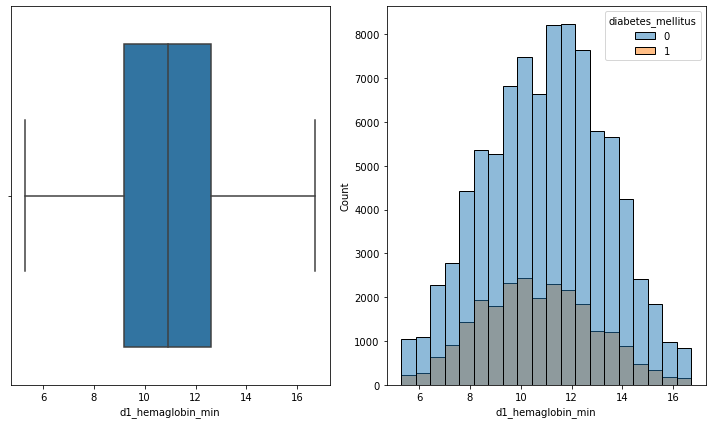

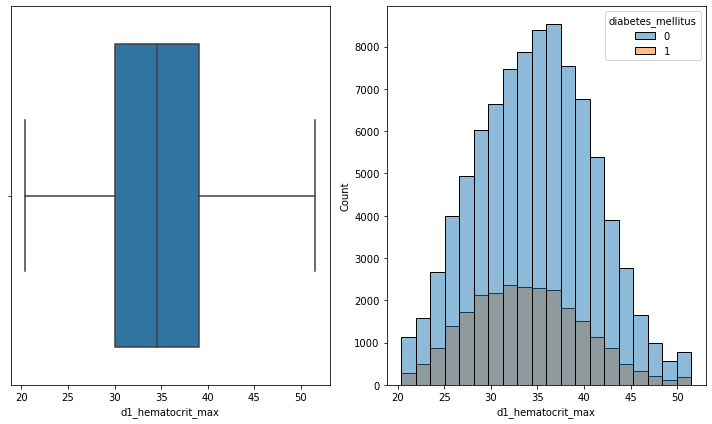

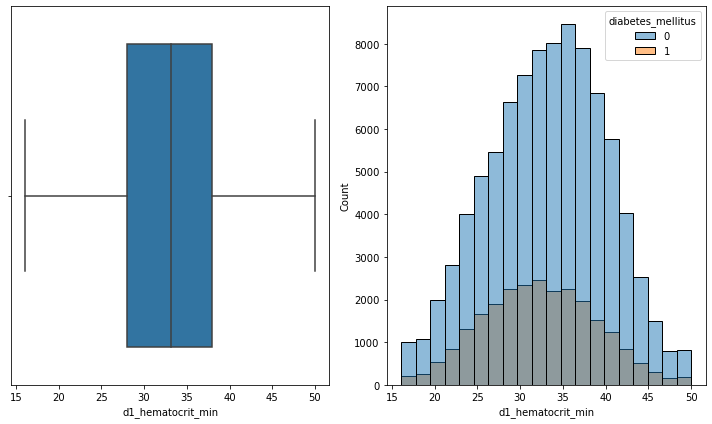

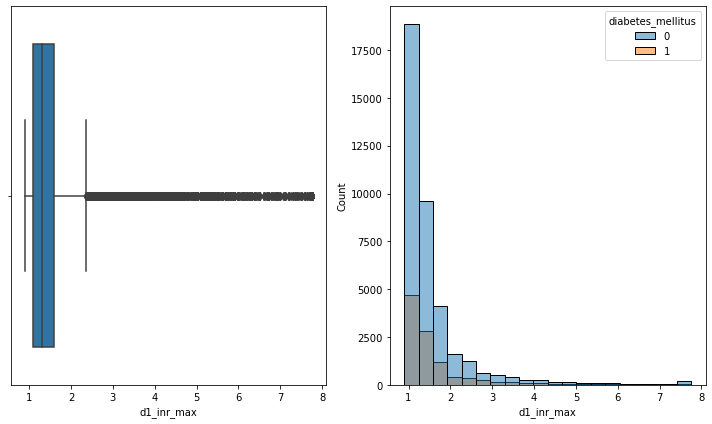

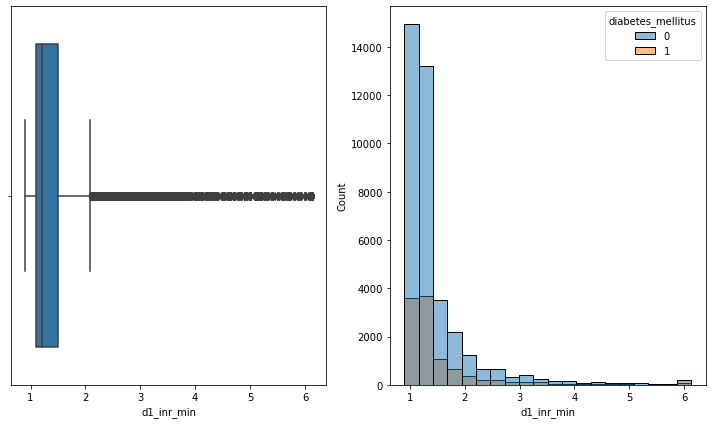

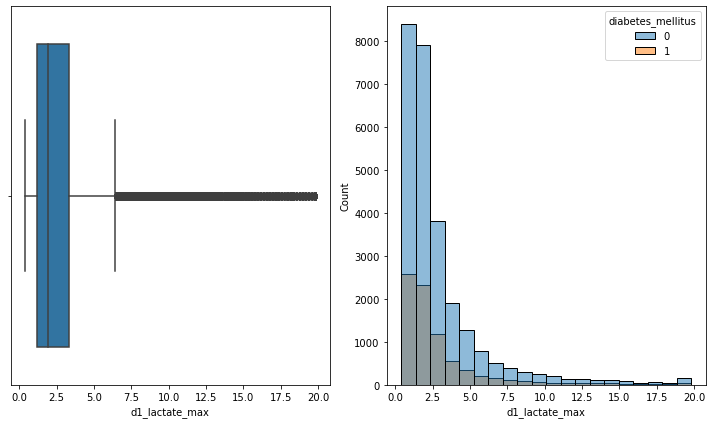

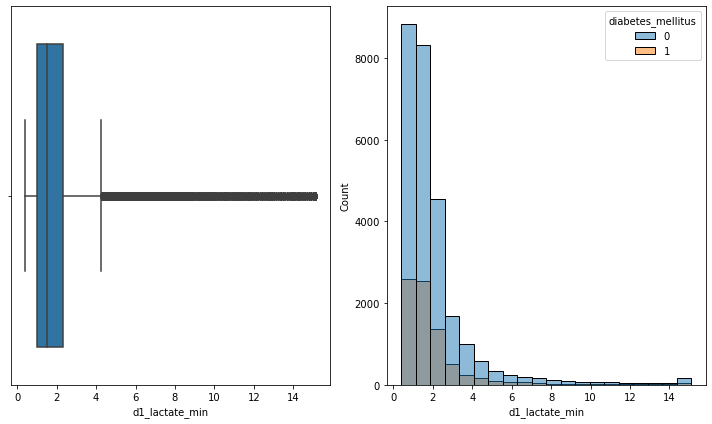

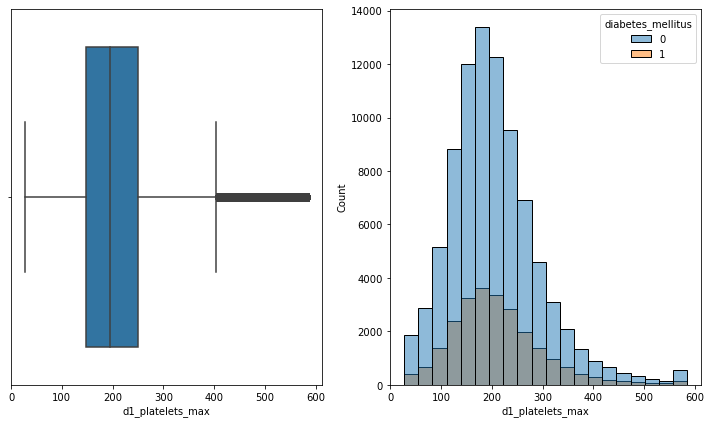

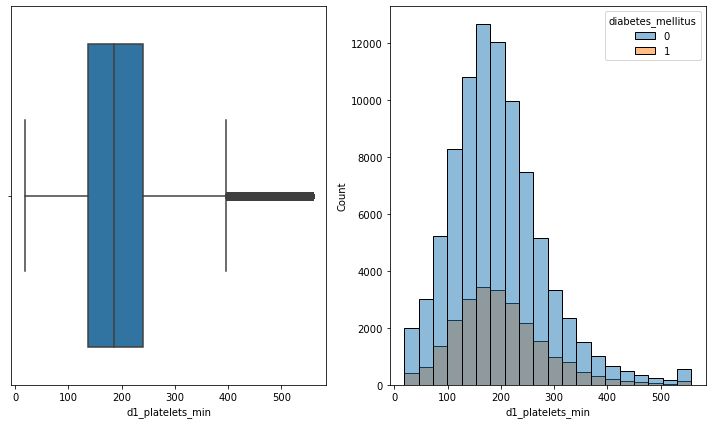

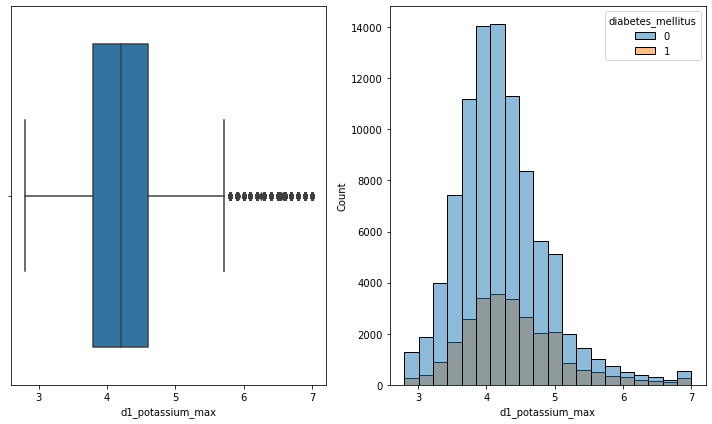

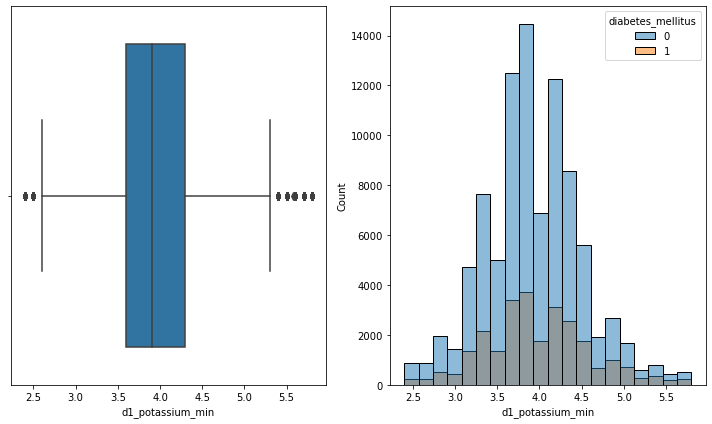

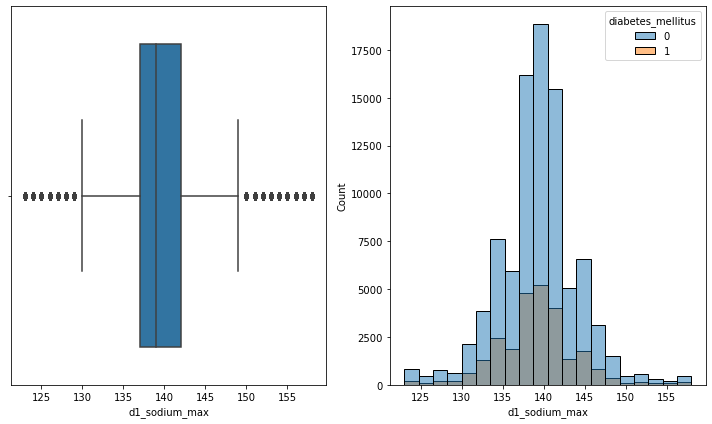

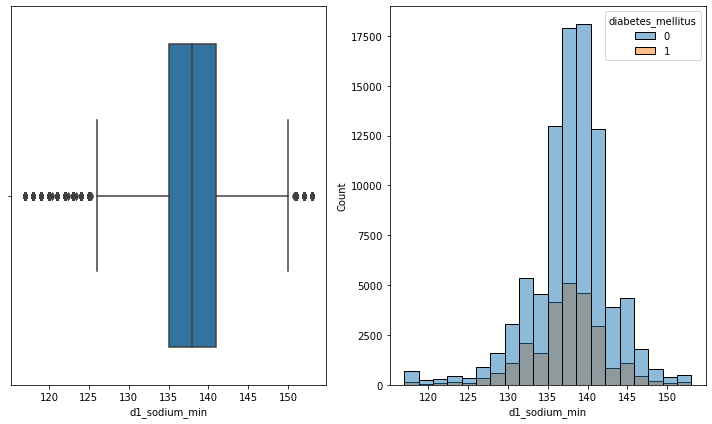

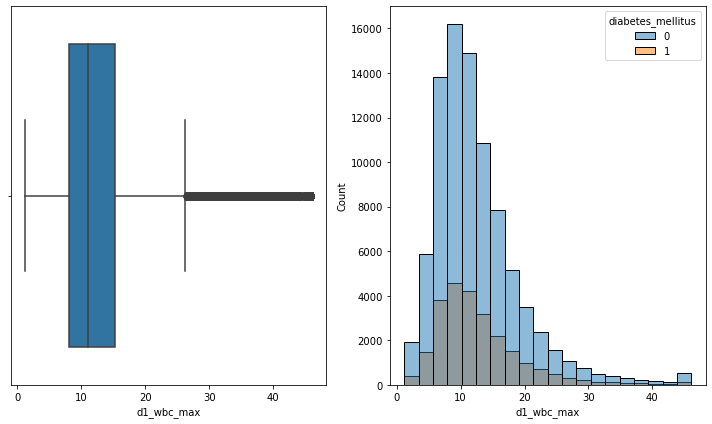

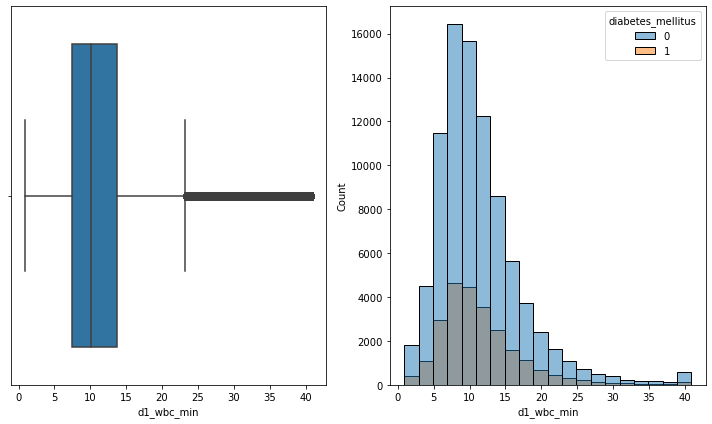

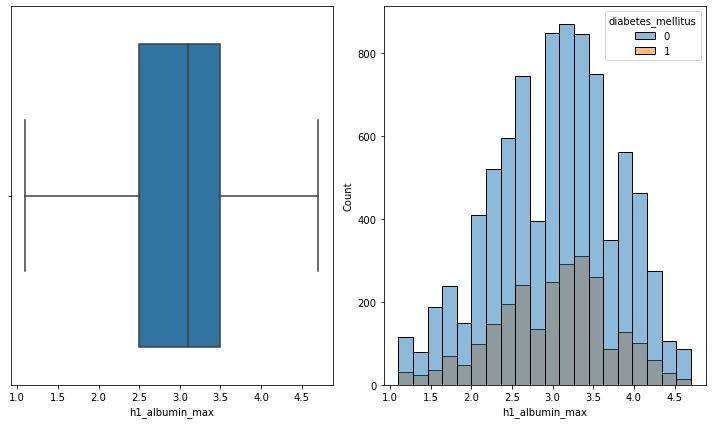

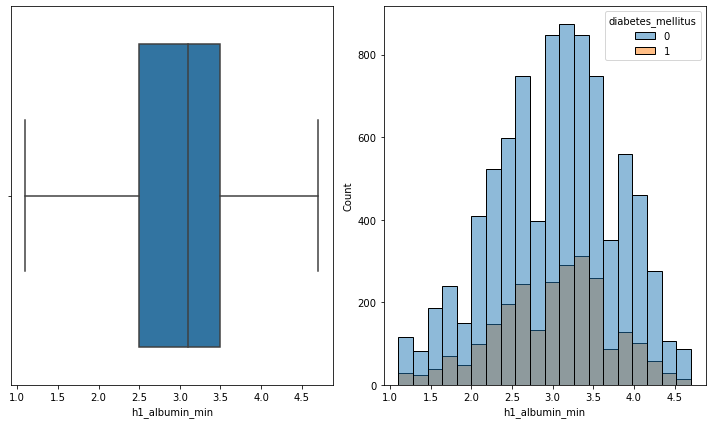

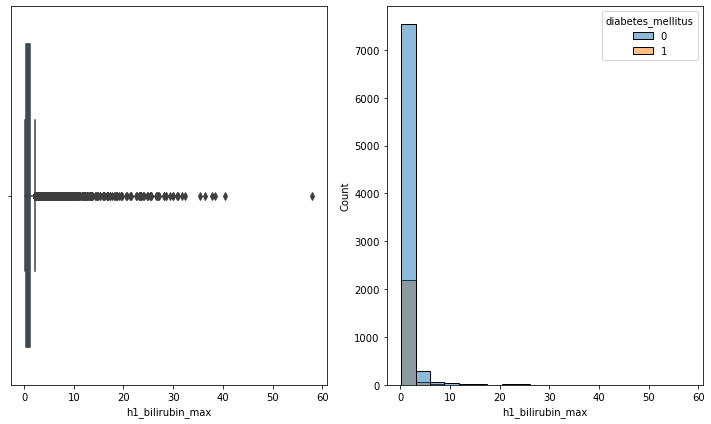

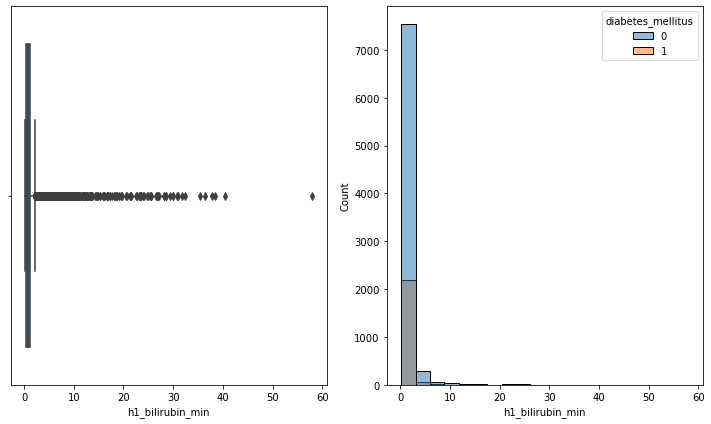

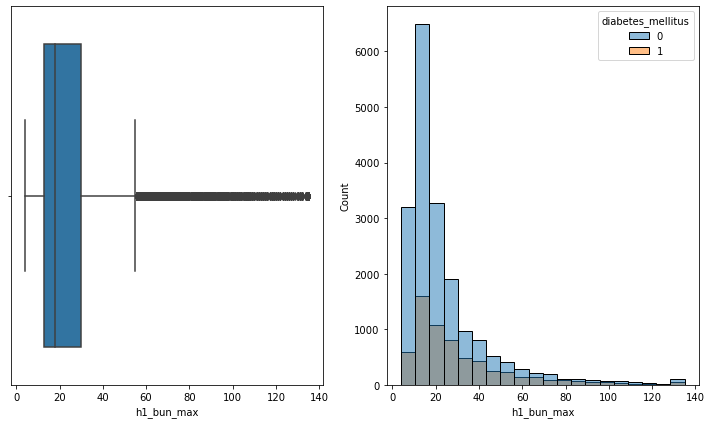

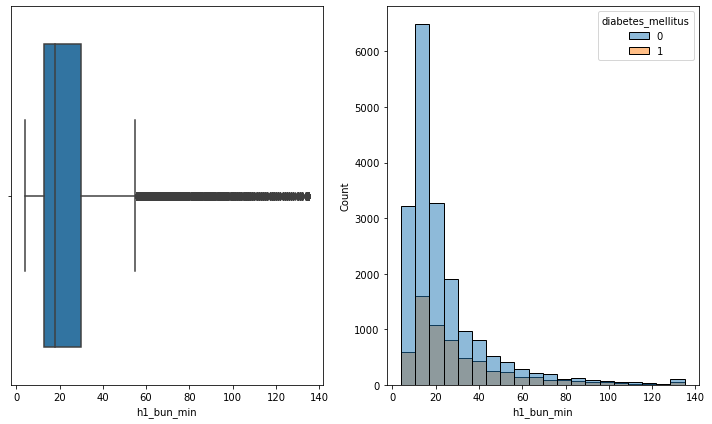

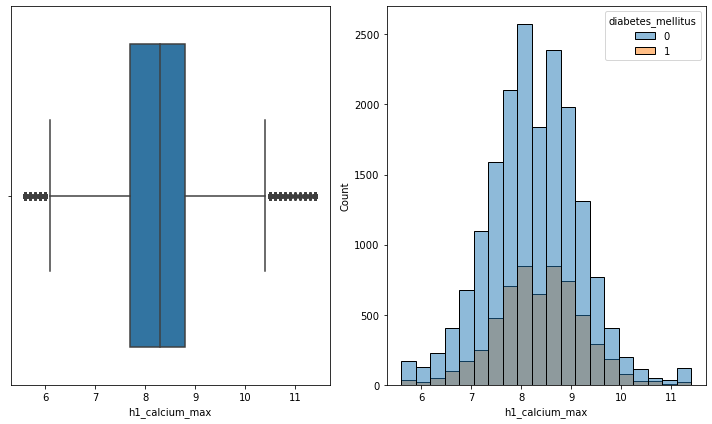

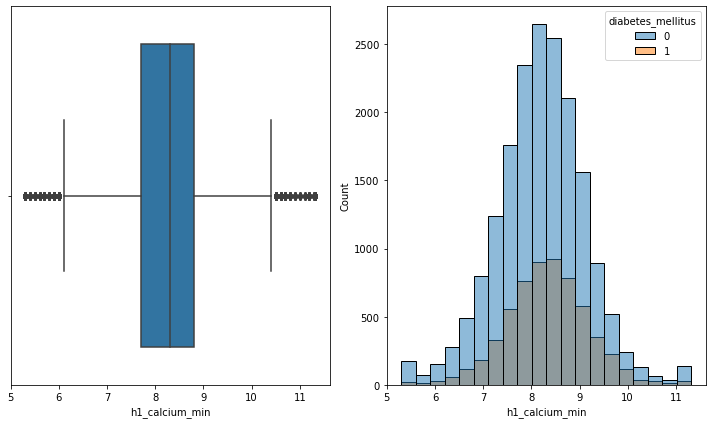

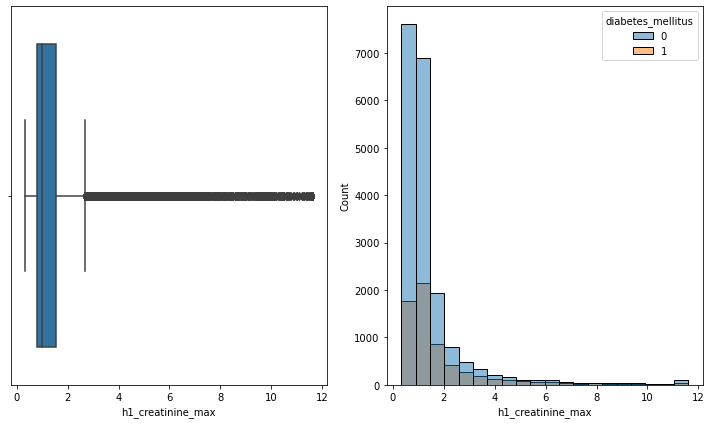

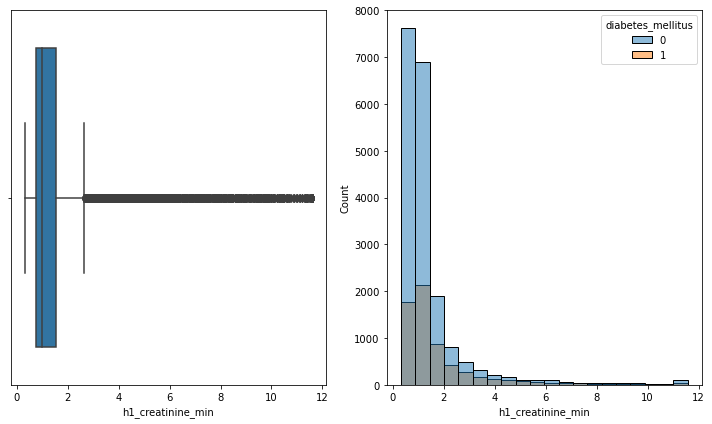

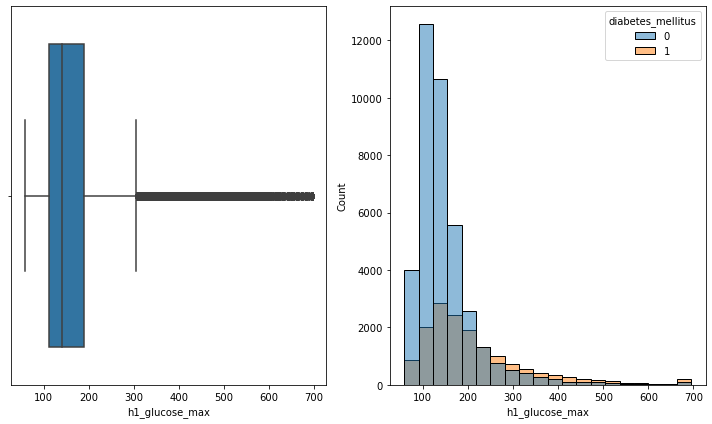

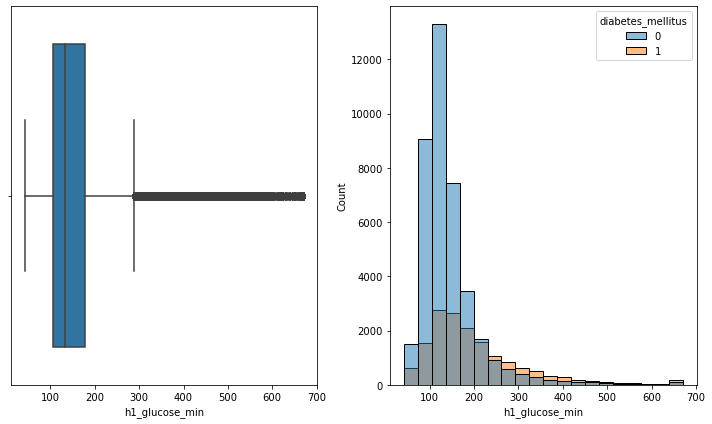

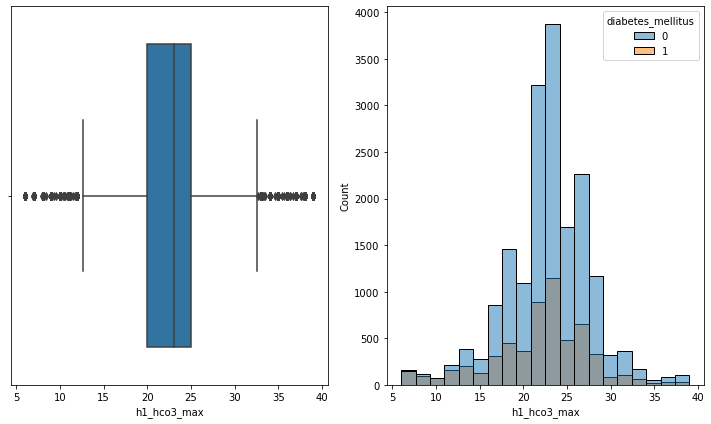

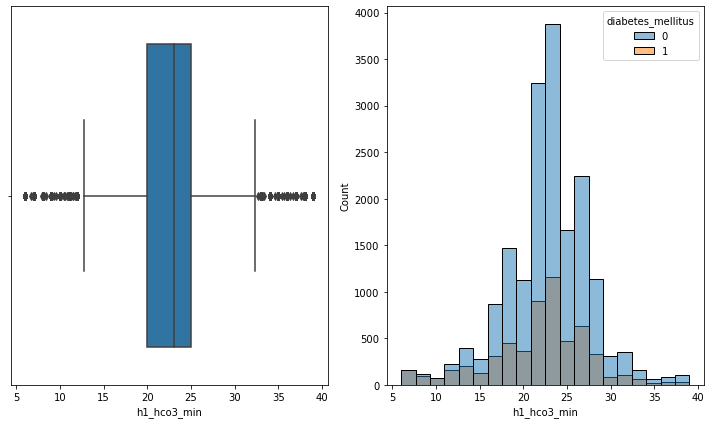

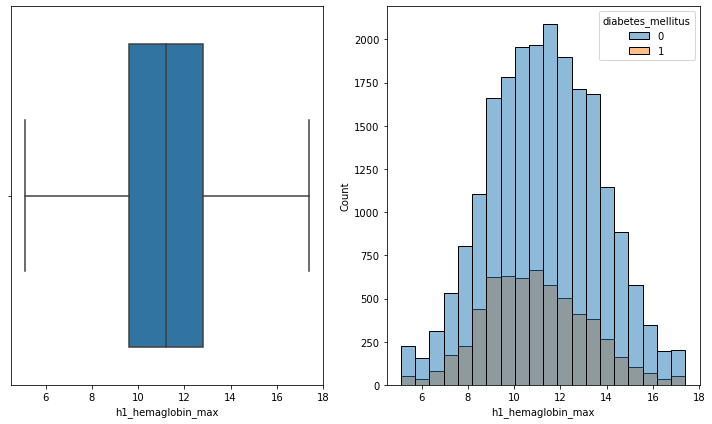

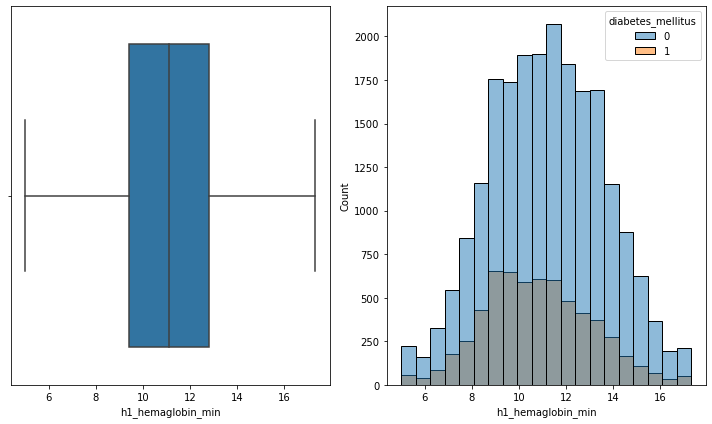

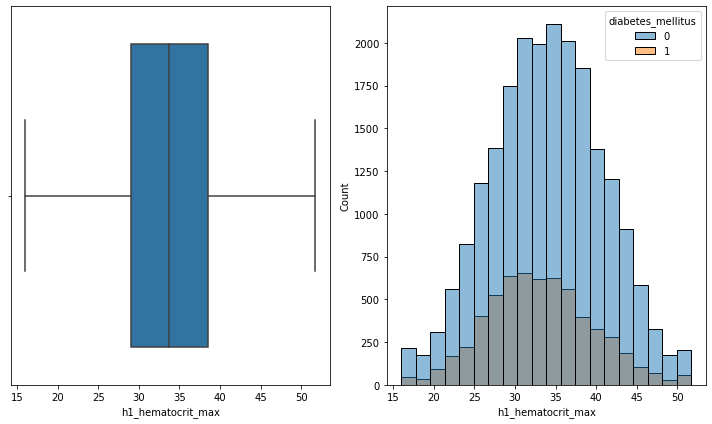

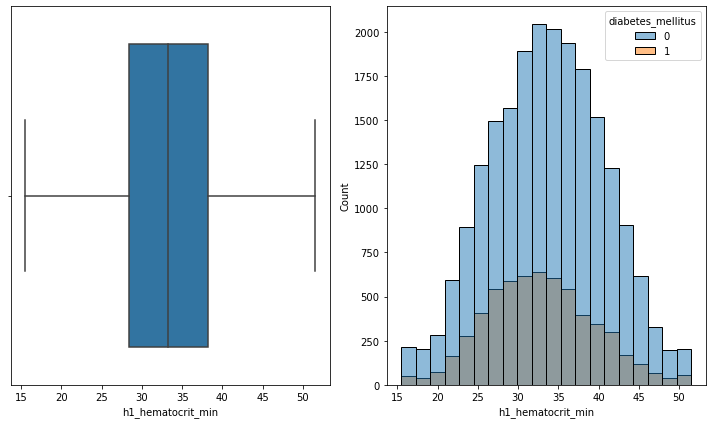

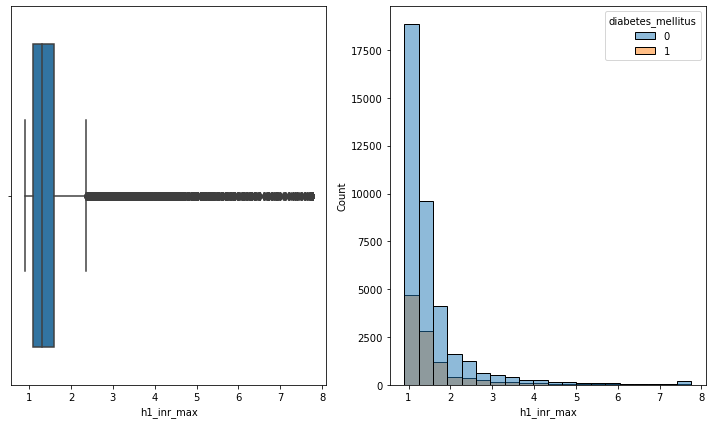

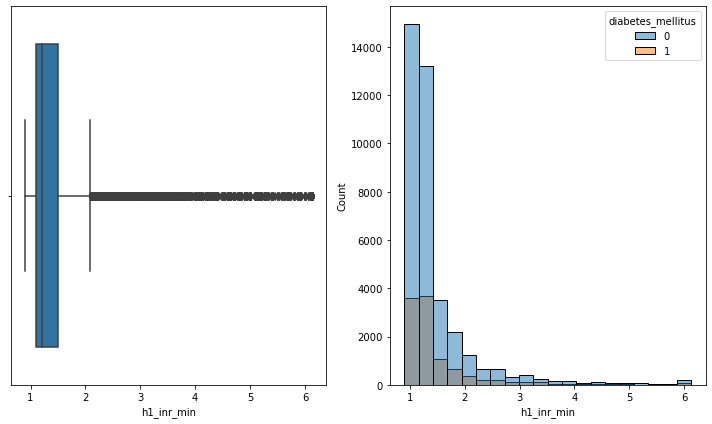

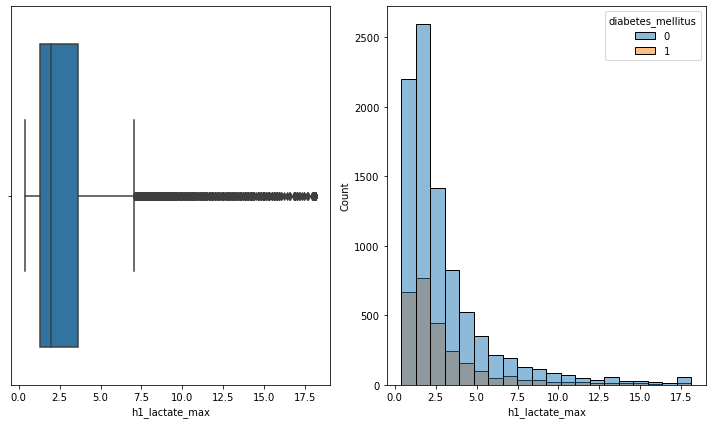

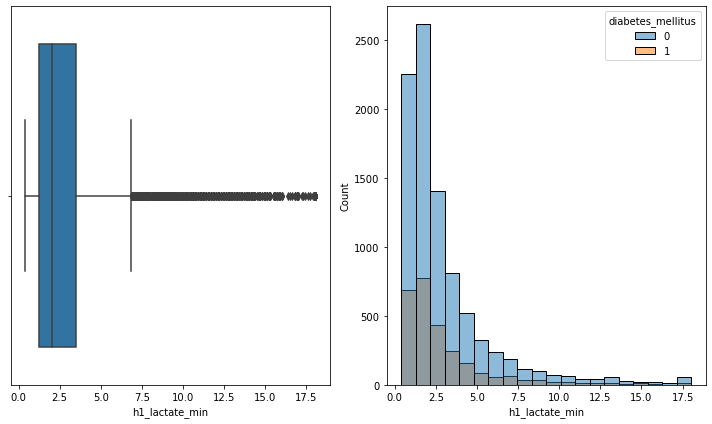

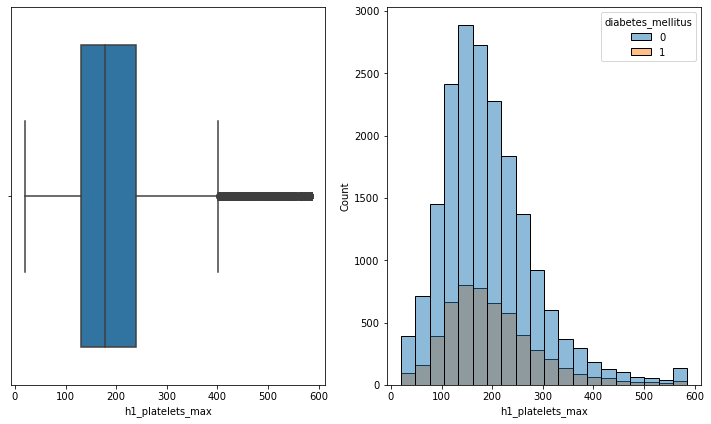

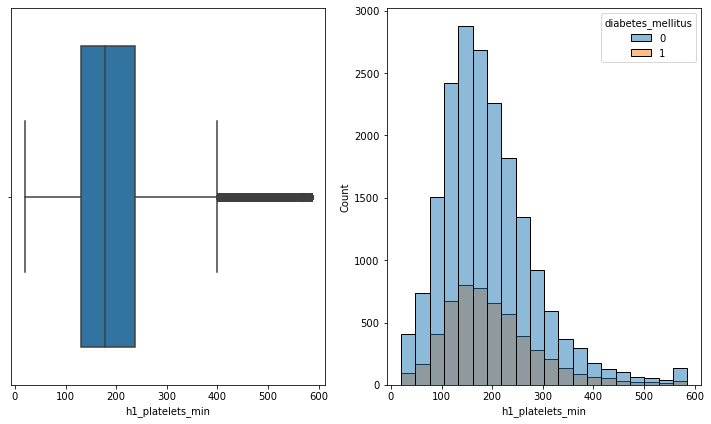

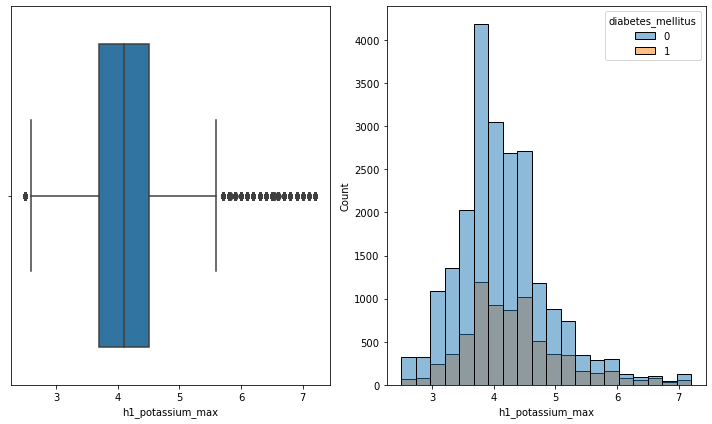

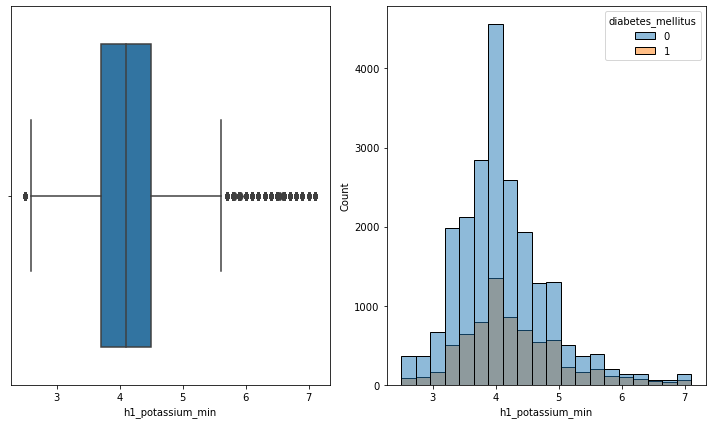

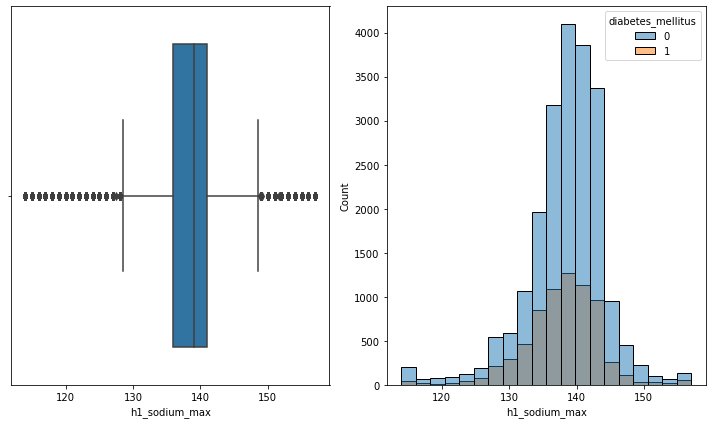

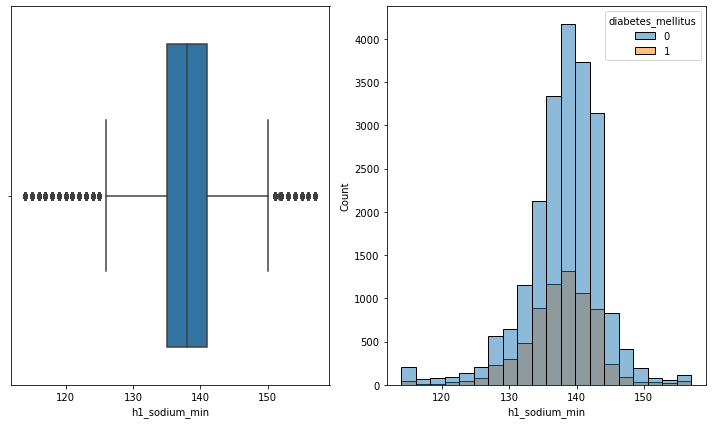

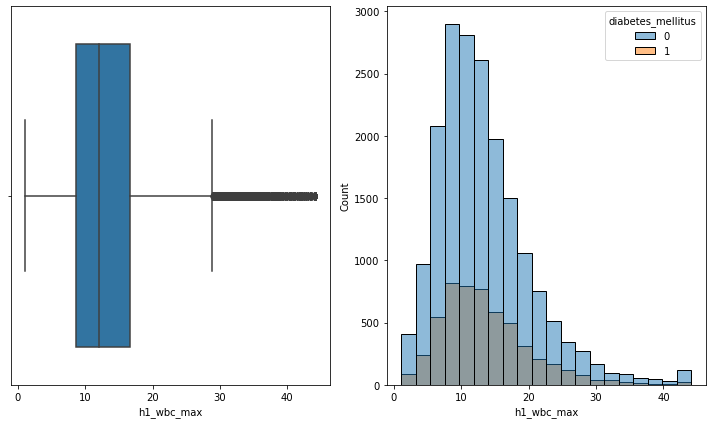

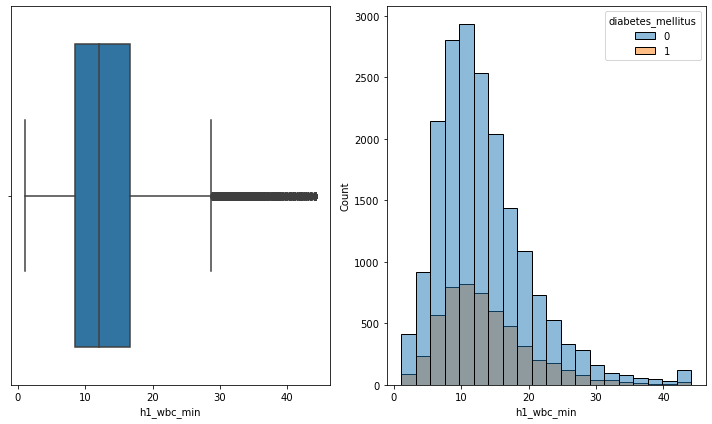

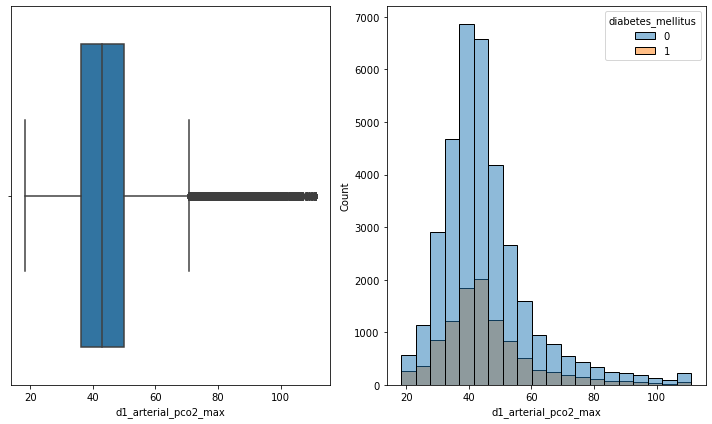

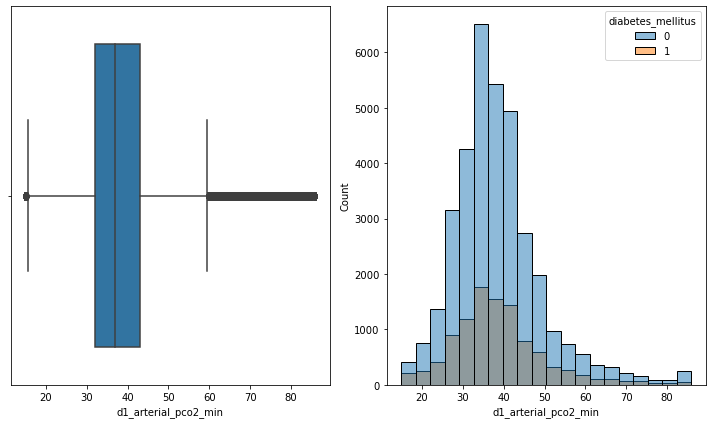

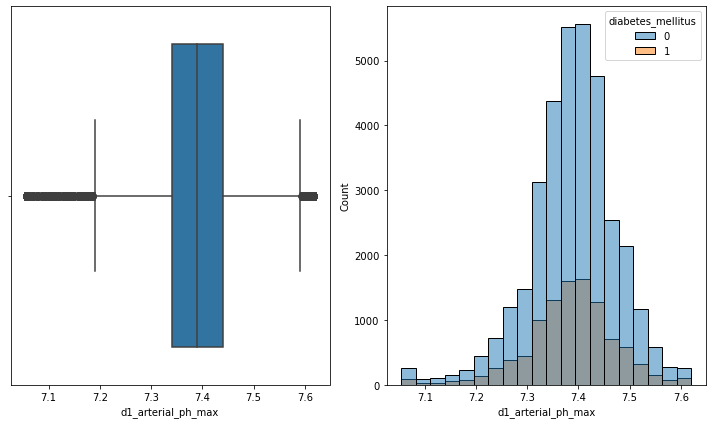

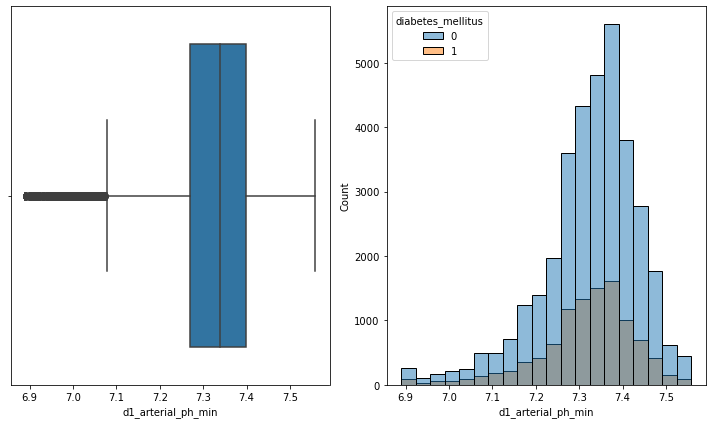

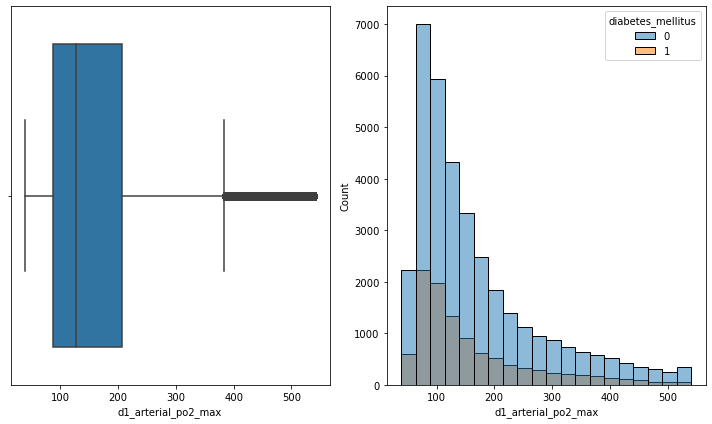

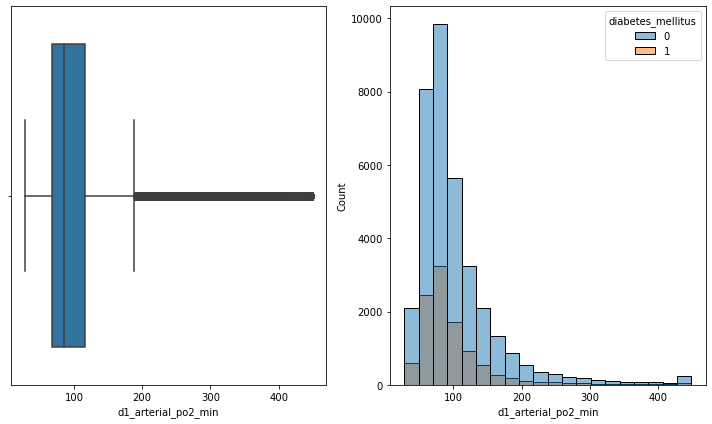

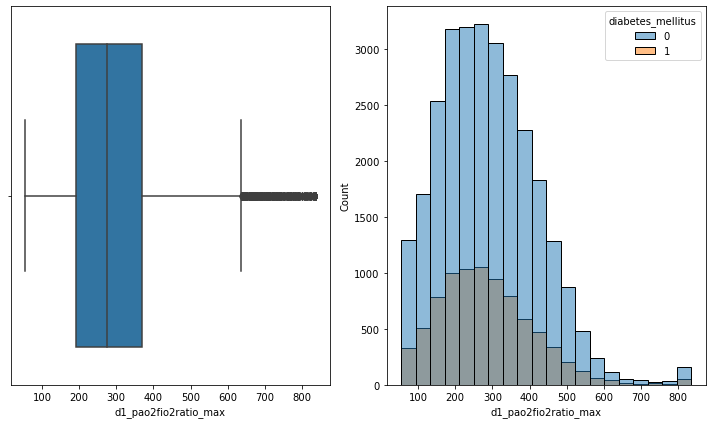

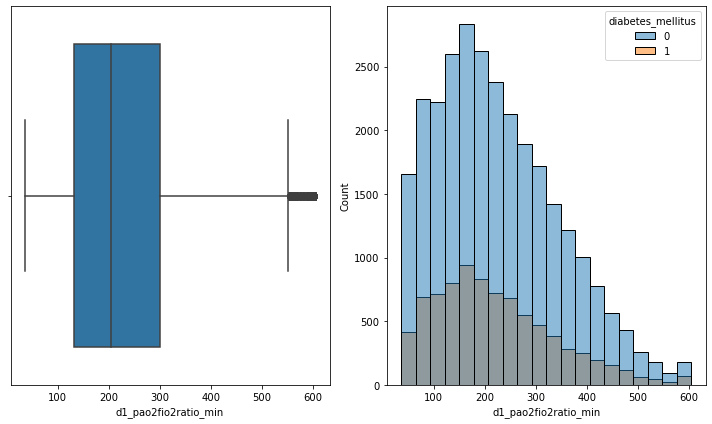

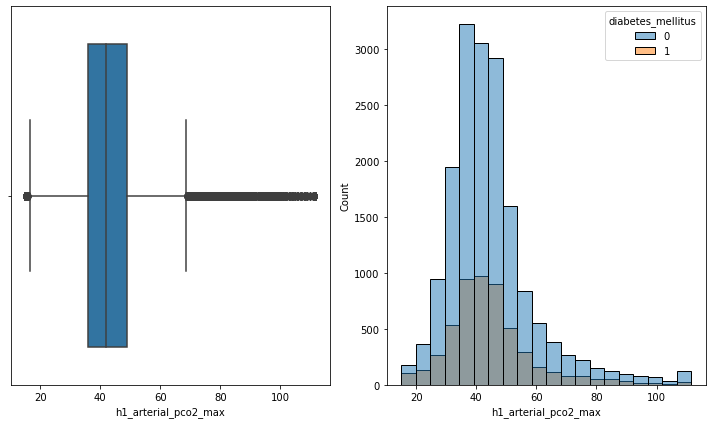

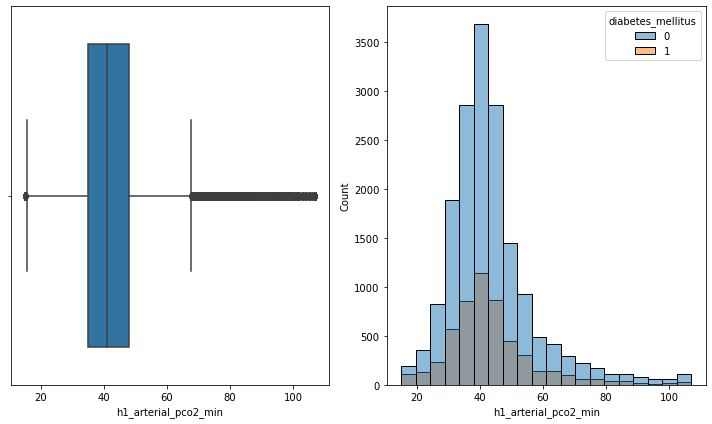

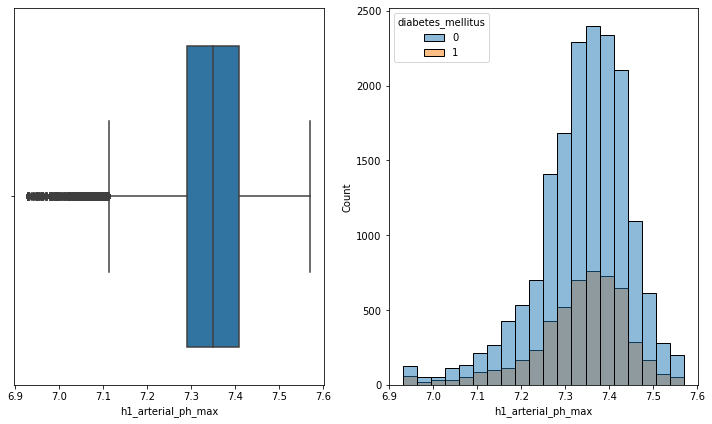

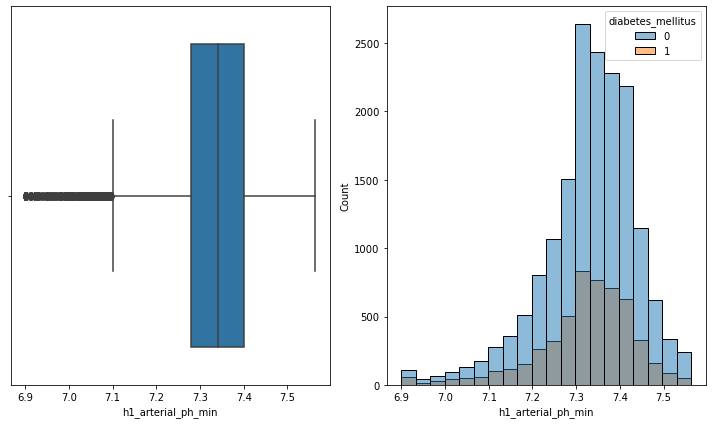

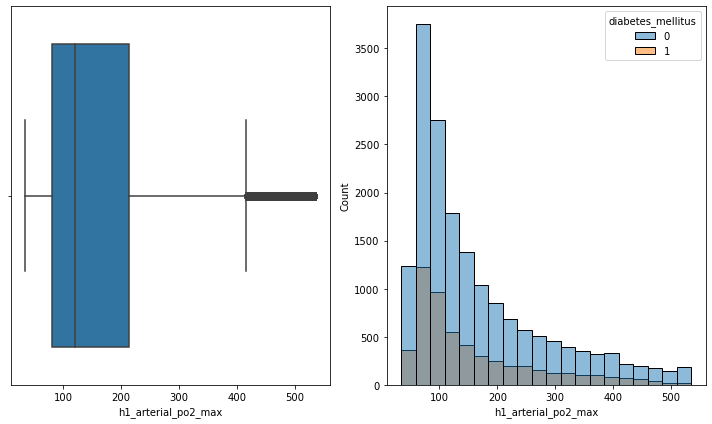

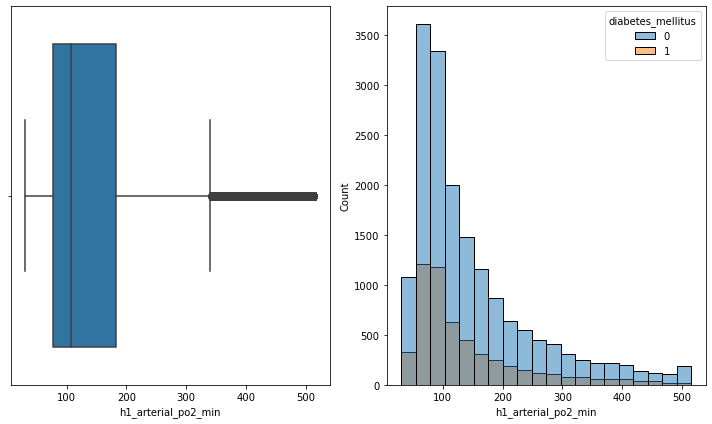

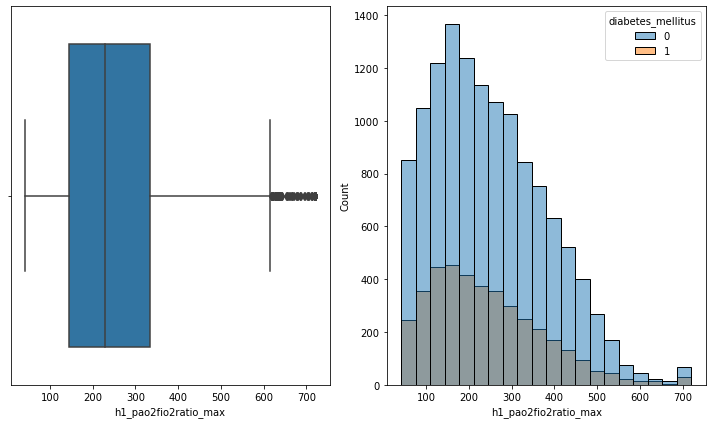

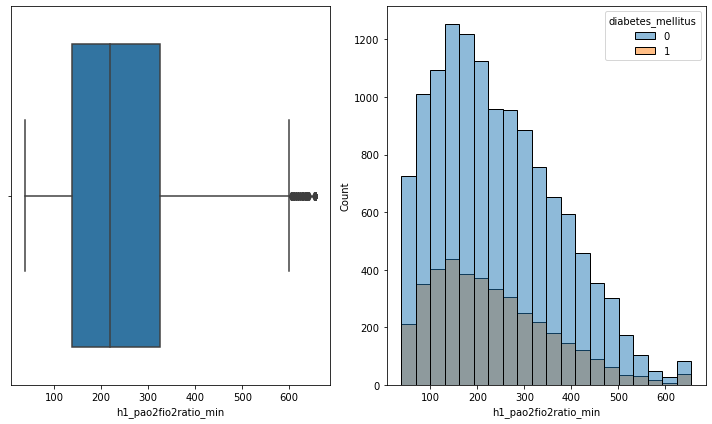

In [37]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(10,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(data = shallow_copy, x = var, hue = 'diabetes_mellitus')
    
    plt.subplot(1, 2, 2)
    fig = sns.histplot(data = shallow_copy, x = var, bins=20, hue = 'diabetes_mellitus')
    
  
    plt.tight_layout()
    plt.show()

For heavily skewed variables, I will use discritization and get intervals to cap outliers. 
For gaussian distibuted variables, I will use 

In [38]:
missing_cont = missing_zero_values_table(shallow_copy[continuous])
missing_cont.style.background_gradient(cmap='Reds')

Your selected dataframe has 154 columns and 130157 Rows.
There are 152 columns that have missing values.


,index,Missing Values,% of Total Values,Data_type
0,h1_bilirubin_max,119861,92.090000,float64
1,h1_bilirubin_min,119861,92.090000,float64
2,h1_albumin_max,119005,91.430000,float64
3,h1_albumin_min,119005,91.430000,float64
4,h1_lactate_min,118467,91.020000,float64
5,h1_lactate_max,118467,91.020000,float64
6,h1_pao2fio2ratio_min,113397,87.120000,float64
7,h1_pao2fio2ratio_max,113397,87.120000,float64
8,h1_arterial_ph_max,107849,82.860000,float64
9,h1_arterial_ph_min,107849,82.860000,float64


In [39]:
for col in continuous:
    shallow_copy[col+'_NA'] = np.where(shallow_copy[col].isnull(), 1, 0)

In [40]:
shallow_copy.head()


,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,age_NA,bmi_NA,height_NA,icu_id_NA,pre_icu_los_days_NA,weight_NA,albumin_apache_NA,apache_2_diagnosis_NA,apache_3j_diagnosis_NA,bilirubin_apache_NA,bun_apache_NA,creatinine_apache_NA,fio2_apache_NA,glucose_apache_NA,heart_rate_apache_NA,hematocrit_apache_NA,map_apache_NA,paco2_apache_NA,paco2_for_ph_apache_NA,pao2_apache_NA,ph_apache_NA,resprate_apache_NA,sodium_apache_NA,temp_apache_NA,urineoutput_apache_NA,wbc_apache_NA,d1_diasbp_invasive_max_NA,d1_diasbp_invasive_min_NA,d1_diasbp_max_NA,d1_diasbp_min_NA,d1_diasbp_noninvasive_max_NA,d1_diasbp_noninvasive_min_NA,d1_heartrate_max_NA,d1_heartrate_min_NA,d1_mbp_invasive_max_NA,d1_mbp_invasive_min_NA,d1_mbp_max_NA,d1_mbp_min_NA,d1_mbp_noninvasive_max_NA,d1_mbp_noninvasive_min_NA,d1_resprate_max_NA,d1_resprate_min_NA,d1_spo2_max_NA,d1_spo2_min_NA,d1_sysbp_invasive_max_NA,d1_sysbp_invasive_min_NA,d1_sysbp_max_NA,d1_sysbp_min_NA,d1_sysbp_noninvasive_max_NA,d1_sysbp_noninvasive_min_NA,d1_temp_max_NA,d1_temp_min_NA,h1_diasbp_invasive_max_NA,h1_diasbp_invasive_min_NA,h1_diasbp_max_NA,h1_diasbp_min_NA,h1_diasbp_noninvasive_max_NA,h1_diasbp_noninvasive_min_NA,h1_heartrate_max

In [41]:
# impute with the mean
for col in continuous:
    median = shallow_copy[col].median()
    shallow_copy[col] = shallow_copy[col].fillna(median)
    
shallow_copy.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,age_NA,bmi_NA,height_NA,icu_id_NA,pre_icu_los_days_NA,weight_NA,albumin_apache_NA,apache_2_diagnosis_NA,apache_3j_diagnosis_NA,bilirubin_apache_NA,bun_apache_NA,creatinine_apache_NA,fio2_apache_NA,glucose_apache_NA,heart_rate_apache_NA,hematocrit_apache_NA,map_apache_NA,paco2_apache_NA,paco2_for_ph_apache_NA,pao2_apache_NA,ph_apache_NA,resprate_apache_NA,sodium_apache_NA,temp_apache_NA,urineoutput_apache_NA,wbc_apache_NA,d1_diasbp_invasive_max_NA,d1_diasbp_invasive_min_NA,d1_diasbp_max_NA,d1_diasbp_min_NA,d1_diasbp_noninvasive_max_NA,d1_diasbp_noninvasive_min_NA,d1_heartrate_max_NA,d1_heartrate_min_NA,d1_mbp_invasive_max_NA,d1_mbp_invasive_min_NA,d1_mbp_max_NA,d1_mbp_min_NA,d1_mbp_noninvasive_max_NA,d1_mbp_noninvasive_min_NA,d1_resprate_max_NA,d1_resprate_min_NA,d1_spo2_max_NA,d1_spo2_min_NA,d1_sysbp_invasive_max_NA,d1_sysbp_invasive_min_NA,d1_sysbp_max_NA,d1_sysbp_min_NA,d1_sysbp_noninvasive_max_NA,d1_sysbp_noninvasive_min_NA,d1_temp_max_NA,d1_temp_min_NA,h1_diasbp_invasive_max_NA,h1_diasbp_invasive_min_NA,h1_diasbp_max_NA,h1_diasbp_min_NA,h1_diasbp_noninvasive_max_NA,h1_diasbp_noninvasive_min_NA,h1_heartrate_max

In [42]:
missing_zero_values_table(shallow_copy[continuous]).head()

Your selected dataframe has 154 columns and 130157 Rows.
There are 0 columns that have missing values.


,index,Missing Values,% of Total Values,Data_type


In [43]:
# # create a log transformer

# transformer = FunctionTransformer(np.log, validate=True)
# # transform all the numerical and positive variables

# train_t = transformer.transform(X_train[cols].fillna(1))
# # Scikit-learn returns NumPy arrays, so capture in dataframe
# # note that Scikit-learn will return an array with
# # only the columns indicated in cols

# train_t = pd.DataFrame(train_t, columns = cols)

In [44]:
# # original distribution

# diagnostic_plots(X_train, 'age')

In [45]:

# def calc_vif(X):

#     # Calculating VIF
#     vif = pd.DataFrame()
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#     return(vif)

In [46]:
# X = shallow_copy.iloc[0:5, 157:166].assign(const=1)
# X

In [47]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from joblib import Parallel, delayed

# # Defining the function that you will run later
# def calculate_vif_(X, thresh=5.0):
#     variables = [X.columns[i] for i in range(X.shape[1])]
#     dropped=True
#     while dropped:
#         dropped=False
#         print(len(variables))
#         vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

#         maxloc = vif.index(max(vif))
#         if max(vif) > thresh:
#             print(' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
#             variables.pop(maxloc)
#             dropped=True

#     print('Remaining variables:')
#     print([variables])
#     return X[[i for i in variables]]

# X = shallow_copy.iloc[0:5, 157:166] # Selecting your data

# X2 = calculate_vif_(X,10) # Actually running the function

In [48]:
# pd.Series([variance_inflation_factor(X.values, i) 
#                for i in range(X.shape[1])], 
#               index=X.columns)

In [49]:
# from statsmodels.tools.tools import add_constant
# X = add_constant(shallow_copy[continuous])
# pd.Series([variance_inflation_factor(X.values, i) 
#                for i in range(X.shape[1])], 
#               index=X.columns)

In [50]:
# calc_vif(shallow_copy[continuous])

In [51]:
# # visualize outliers
# !pip install pyod -q
# from pyod.models.abod import ABOD


# Removing high correlated data

In [52]:
# X.columns

In [53]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor    

# def calculate_vif_(X, thresh=5.0):
#     variables = list(range(X.shape[1]))
#     dropped = True
#     while dropped:
#         dropped = False
#         vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
#                for ix in range(X.iloc[:, variables].shape[1])]

#         maxloc = vif.index(max(vif))
#         if max(vif) > thresh:
#             print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
#                   '\' at index: ' + str(maxloc))
#             del variables[maxloc]
#             dropped = True

#     print('Remaining variables:')
#     print(X.columns[variables])
#     return X.iloc[:, variables]